# Assignment 5

**Submission deadlines:**
- get at least 4 points by Tuesday, 8.06 
- remaining points: last lab session of the semester

**Points:** Aim to get 12 out of 16 possible points.


## Submission instructions
The class is held remotely. To submit your solutions please show the notebook over the video call. Make sure you know all the questions and answers, and that the notebook contains results (before presentation do `Runtime -> Restart and run all`)

We provide a starter code, however, you are not required to use it as long as you properly solve the tasks.

As always, please submit corrections using GitHub's Pull Requests to https://github.com/janchorowski/dl_uwr.

# Problem 1: Generating 2 Moons data
Consider the 2D moons dataset generated in the starter code below. 

Train the following models: VAE, GAN, RealNVP. 

For each model visualize how the latent space is transformed into data points. Train a model with 2D latent space. Then whenever applicable:
1. Plot the data points along with a grid, then plot latent encodings of the data and the grid.
2. Generate latent encodings and a grid in latent space. Then sample data points based on the generated latent space and grid. Plot them in the data space.

Hint: for better visual mapping between original and latent representations of the data, use color on the scatterplots.

## Tasks:
1. [4p] Variational Autoencoder (VAE)

  Please use the following probability distributions:
    
  $$
    \begin{split}
    p(z) &= \mathcal{N}(z; \mu=0, \sigma^2=1)  \\
    p(x | z) &= \mathcal{N}(x; \mu=x_{\mu}(z), \sigma^2=x_{\sigma^2})
    \end{split}
  $$

  where: $x_{\mu}(z)$ is computed by a small neural network and $x_{\sigma^2}$ is a learned parameter.

  **Answer these questions:**
  
  1. Write down the formula for the reconstruction loss. The variance appears in two terms, what is their function?

  2. The reconstruction loss may fall below zero. How is this possible? 

  Compare the operation of the VAE for 2 Moons with a few widths. How is the loss dependent on the width? Why?

2. [3p] Generative Adversarial Network (GAN)

  Please use either a standard normal distribution for the latent space or a uniform distribution.

  **Answer these questions:**
  - Is the GAN generating all possible samples? Is it concentrating more on some regions of the data space?

3. [3p] Normalizing Flow (Real NVP model).

  The goal of Normalizing Flows is to learn invertible transformation between complex data distribution and some simple one, i.e. multivariate isotropic Gaussian. Since the latter is continuous, and our dataset is finite (hence in fact forms a discrete distribution, because you can memorize all observed values), we need to perform *dequantization*, that is add random noise to data at every iteration to train the model on an infinite stream of data. This is especially important in Problem 2 when RealNVP is applied to the MNIST data.

    **Answer these questions:**
  - Scale the input data by 0.01. Why is the negative log-likelihood negative?
  - For a few 2 moon widths compare the negative log-likelihood of the data with the values obtained with the VAE and present results in a table. How do they compare? Please note, that GAN's do not return likelihood computation.


# Problem 2: Generating MNIST

Next, choose one of the generative models (VAE, RealNVP, or GAN) and do the following using the MNIST dataset:

##Tasks
1. [2p] Train the model. Visualize generated samples (and test/train data reconstructions if you chose VAE).

Please properly define $p(x|z)$: when using a VAE, you can binarize the data and predict binary variables. For RealNVP, you can normalize the data to the 0-1 range, and add uniform noise $[0,1/255]$ to dequantize intensity values. GAN does not assume an output probability distribution and you may use raw data.

2. [1p] Linearly interpolate between two points in the latent space. Generate images from them and intermediate points. 

3. [1p] Try a different interpolation method, i.e. instead of going in a straight line from one point to another, follow the spherical curve of prior Gaussian distribution.

4. [2p] It is sometimes desirable to make use of available labels to gain control over classes of generated samples. Create a conditional generative model of your choice by injecting one-hot embeddings into the proper component(s). An example is [Conditional GAN](https://arxiv.org/abs/1411.1784), and its idea is applicable to other methods.


# Starter code

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import MultivariateNormal, Uniform
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose

device = "cuda"

## Data

In [ ]:
def generate_moons(width=1.0):
    moon1 = [
        [r * np.cos(a) - 2.5, r * np.sin(a) - 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(0, np.pi, 0.01)
    ]
    moon2 = [
        [r * np.cos(a) + 2.5, r * np.sin(a) + 1.0]
        for r in np.arange(5 - width, 5 + width, 0.1 * width)
        for a in np.arange(np.pi, 2 * np.pi, 0.01)
    ]
    points = torch.tensor(moon1 + moon2)
    points += torch.rand(points.shape) * width
    return points.float()

In [ ]:
class InMemDataLoader(object):
    __initialized = False
    def __init__(self, tensors, batch_size=1, shuffle=False, sampler=None,
                 batch_sampler=None, drop_last=False):
        """A torch dataloader that fetches data from memory."""
        tensors = [torch.tensor(tensor) for tensor in tensors]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last
        
        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')
            
        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(sampler, batch_size, drop_last)

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True
    
    def __setattr__(self, attr, val):
        if self.__initialized and attr in ('batch_size', 'sampler', 'drop_last'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)
    
    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


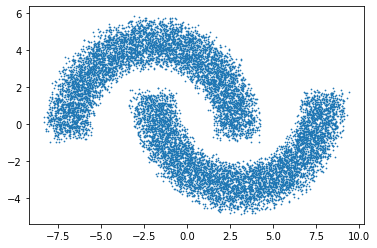

In [ ]:
moons = generate_moons(width=1.0)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

## VAE

In [ ]:
def get_grid(data):
    """Generate a dataset of points that lie on grid and span the given data range."""

    xmin, xmax = np.floor(data.min(0)), np.ceil(data.max(0))
    xg, yg = np.meshgrid(
        np.arange(xmin[0], xmax[0] + 1, 1), np.arange(xmin[1], xmax[1] + 1, 1)
    )
    mxg = np.hstack(
        (
            np.hstack((xg, np.zeros((xg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((xg.T, np.zeros((xg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    myg = np.hstack(
        (
            np.hstack((yg, np.zeros((yg.shape[0], 1)) + np.nan)).ravel(),
            np.hstack((yg.T, np.zeros((yg.shape[1], 1)) + np.nan)).ravel(),
        )
    )
    grid = np.vstack((mxg, myg)).T
    return grid

In [ ]:
from torch.autograd import Variable
class VAE(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, z_dim=2):
        super(VAE, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, 2 * z_dim),
        )

        self.decoder = nn.Sequential(
            nn.Linear(z_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, in_dim),
        )

        self.x_log_var = torch.nn.Parameter(torch.zeros(in_dim))

    def forward(self, x):
        sampled_z, z_mu, z_log_var = self.encode(x)
        x_mu, x_log_var = self.decode(sampled_z)
        return x_mu, x_log_var, z_mu, z_log_var


    def encode(self, x):
        # Implement encoding procedure.
        # First, get z_mu and z_log_var from the encoder.
        # Second, compute z samples using the  the reparametrization trick.
        # TODO
        z_mu_log_var = self.encoder(x)
        z_mu, z_log_var = torch.chunk(z_mu_log_var, 2, dim=1)
       
        epsilon = MultivariateNormal(torch.zeros(z_dim, device = device), torch.eye(z_dim, device = device)).sample((x.shape[0],))
        sampled_z = z_mu + torch.sqrt(torch.exp(z_log_var)) * epsilon
  
        return sampled_z, z_mu, z_log_var

    def decode(self, sampled_z):
        x_mu = self.decoder(sampled_z)
        return x_mu, self.x_log_var

In [ ]:
# ?torch.eye
# ?nn.GaussianNLLLoss()
?log_prob



Object `log_prob` not found.


In [ ]:

def gaussian_negative_log_likelihood(x, mu, log_var):
    """Compute N(x; mu=mu, sigma^2=exp(log_var)^2)."""
    # length = x.shape[0]*x.shape[1]
    # dist = torch.distributions.Normal(loc=torch.zeros(size=(length,), device = x.device), scale = torch.ones(size=(length,), device = x.device))
    a = (x - mu) ** 2  # works on multiple samples thanks to tensor broadcasting
    log_p = (log_var + a / log_var.exp()).sum(-1)
    log_p = -0.5 * ( np.log(2 * np.pi) + log_p )

    return log_p

def kullback_leibler_divergence_between_two_gaussians(mu1, log_var1, mu2, log_var2):
    return (
        log_var2 - log_var1 + (log_var1.exp() + (mu1 - mu2) ** 2) / (log_var2.exp()) - 1
    ) / 2


def reconstruction_loss(predicted_x_mu, predicted_x_log_var, real_x):
    """Return the negtive log-likelihood reconstruction loss:
        1/N \sum_i=1^N -\log N(x_i ; predicted_x_mu, I * exp(predicted_x_log_var)^2)
    """
    return -gaussian_negative_log_likelihood(x=real_x, mu=predicted_x_mu, log_var=predicted_x_log_var).mean()


def kl_loss(z_mu, z_log_var):
    """Compute Kullback–Leibler divergence between N(z_mu, exp(z_log_var)^2) and N(0,1).

    """
    return kullback_leibler_divergence_between_two_gaussians(z_mu, z_log_var, torch.zeros_like(z_mu) ,torch.ones_like(z_log_var)).max()


In [ ]:
hid_dim = 64
z_dim = 2
lr = 0.0003

vae = VAE(hid_dim=hid_dim, z_dim=z_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)

Epoch: 0 loss: 14.4188 recon_loss: 14.1183 kl_loss: 0.3005 avg mean: -0.1214 avg std: 1.0398


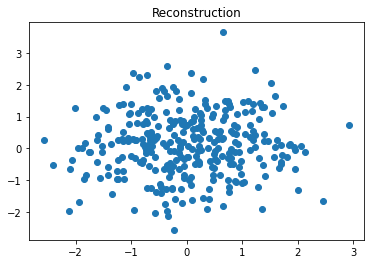

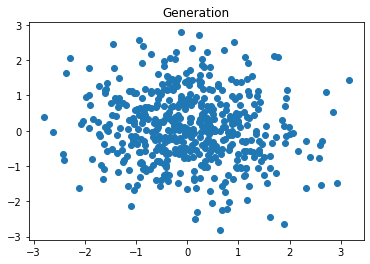

Epoch: 200 loss: 3.1897 recon_loss: 1.5747 kl_loss: 1.6150 avg mean: -0.1101 avg std: 0.3424


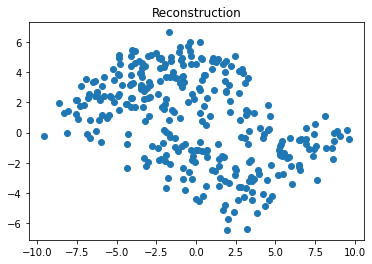

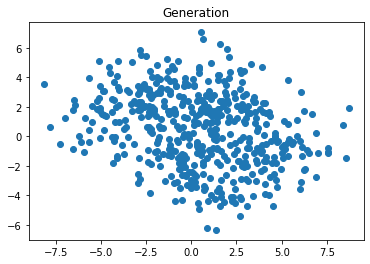

Epoch: 400 loss: 2.9397 recon_loss: 1.3221 kl_loss: 1.6176 avg mean: -0.0818 avg std: 0.3204


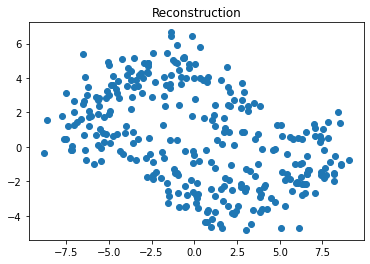

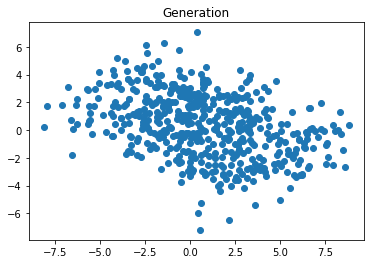

Epoch: 600 loss: 2.7097 recon_loss: 1.0434 kl_loss: 1.6662 avg mean: -0.0495 avg std: 0.3008


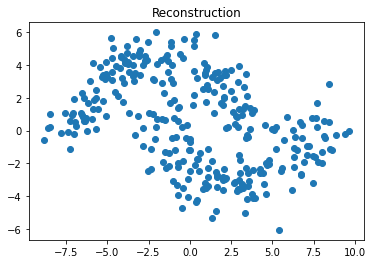

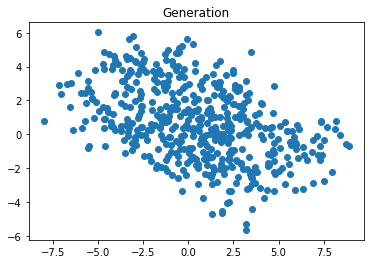

Epoch: 800 loss: 2.5458 recon_loss: 0.7619 kl_loss: 1.7839 avg mean: 0.0217 avg std: 0.2784


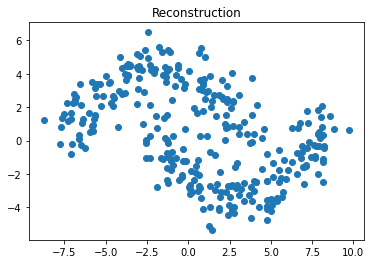

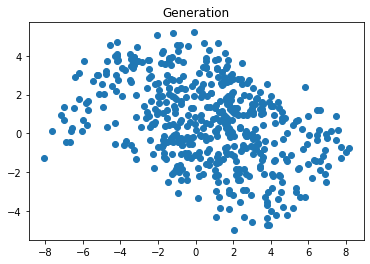

Epoch: 1000 loss: 2.3485 recon_loss: 0.4091 kl_loss: 1.9393 avg mean: -0.0168 avg std: 0.2323


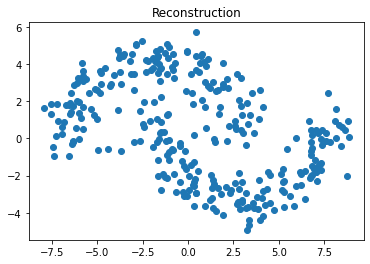

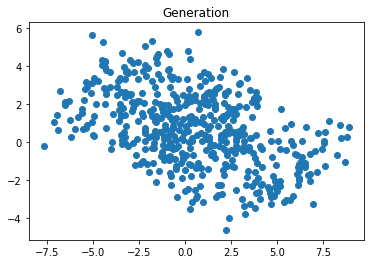

Epoch: 1200 loss: 2.1337 recon_loss: -0.0291 kl_loss: 2.1628 avg mean: -0.0806 avg std: 0.1819


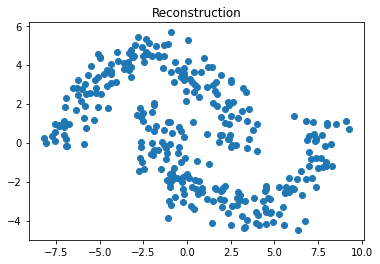

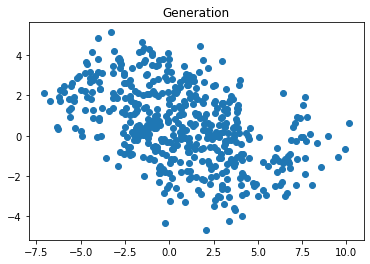

Epoch: 1400 loss: 1.9020 recon_loss: -0.4890 kl_loss: 2.3910 avg mean: 0.0355 avg std: 0.1452


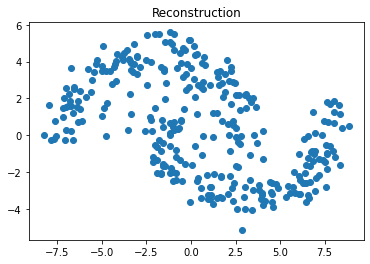

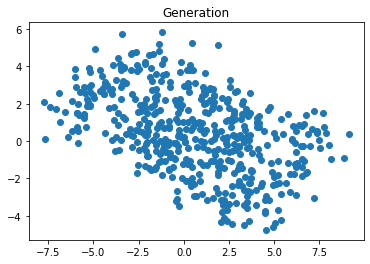

Epoch: 1600 loss: 1.6806 recon_loss: -0.9085 kl_loss: 2.5891 avg mean: -0.0294 avg std: 0.1177


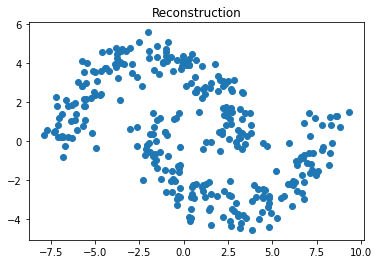

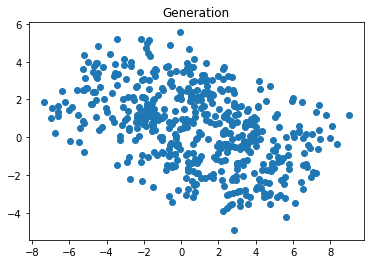

Epoch: 1800 loss: 1.4593 recon_loss: -1.3357 kl_loss: 2.7950 avg mean: -0.0171 avg std: 0.0988


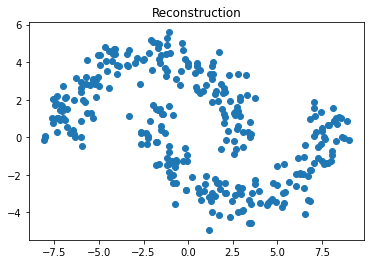

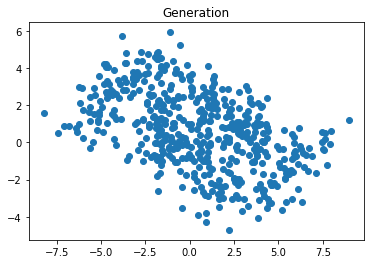

Epoch: 2000 loss: 1.2456 recon_loss: -1.7610 kl_loss: 3.0066 avg mean: 0.0276 avg std: 0.0802


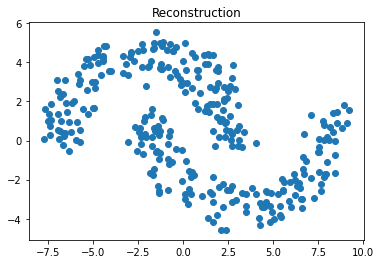

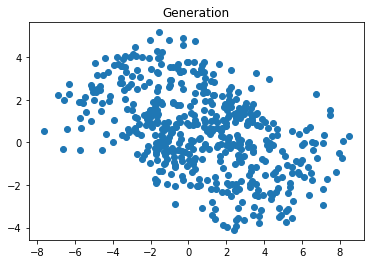

Epoch: 2200 loss: 1.0483 recon_loss: -2.1708 kl_loss: 3.2191 avg mean: -0.1571 avg std: 0.0661


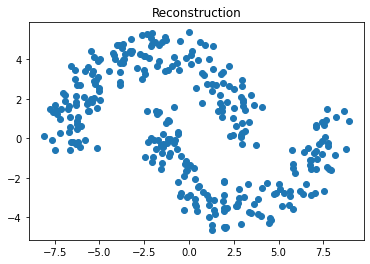

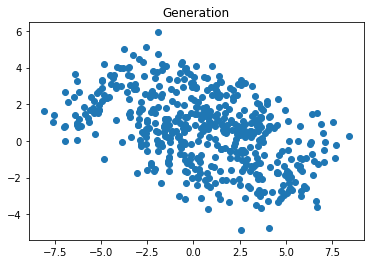

Epoch: 2400 loss: 0.8258 recon_loss: -2.5960 kl_loss: 3.4217 avg mean: 0.0039 avg std: 0.0515


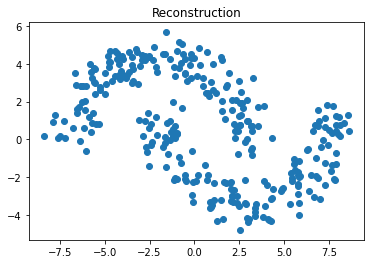

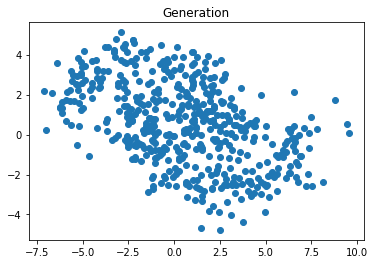

Epoch: 2600 loss: 0.6417 recon_loss: -2.9992 kl_loss: 3.6408 avg mean: -0.0130 avg std: 0.0434


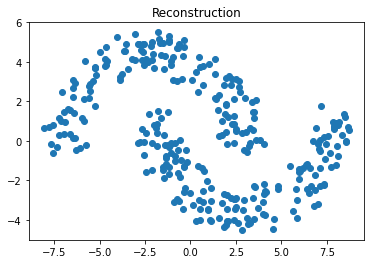

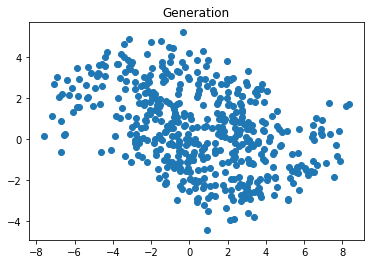

Epoch: 2800 loss: 0.4368 recon_loss: -3.4045 kl_loss: 3.8413 avg mean: -0.0759 avg std: 0.0348


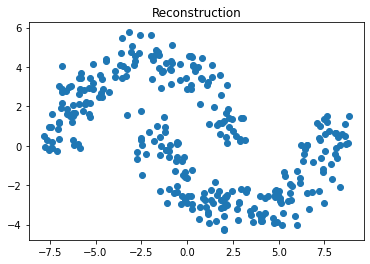

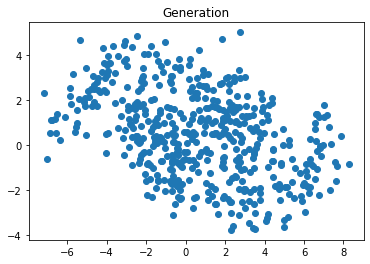

Epoch: 3000 loss: 0.2205 recon_loss: -3.8279 kl_loss: 4.0484 avg mean: -0.0359 avg std: 0.0286


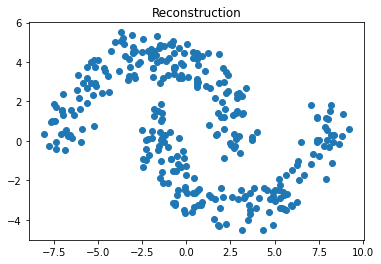

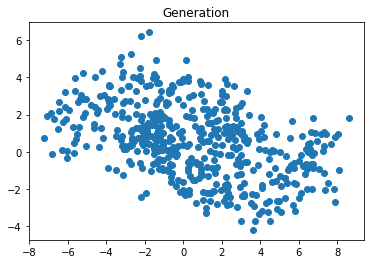

Epoch: 3200 loss: 0.0486 recon_loss: -4.2112 kl_loss: 4.2599 avg mean: 0.0257 avg std: 0.0233


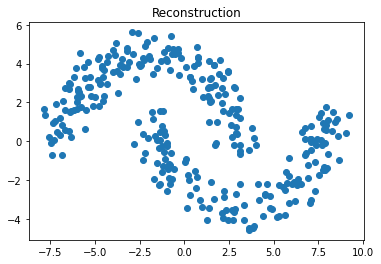

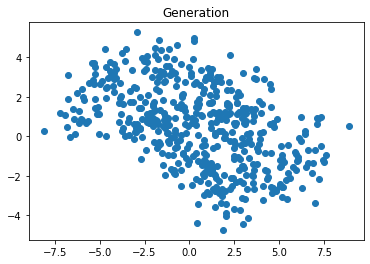

Epoch: 3400 loss: -0.1294 recon_loss: -4.5894 kl_loss: 4.4599 avg mean: 0.0079 avg std: 0.0188


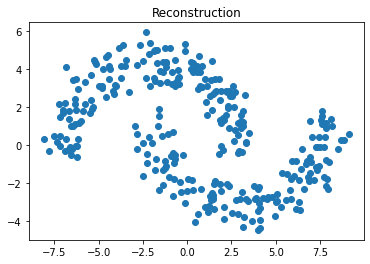

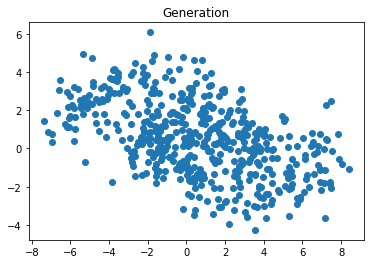

Epoch: 3600 loss: -0.3182 recon_loss: -4.9769 kl_loss: 4.6587 avg mean: -0.0852 avg std: 0.0151


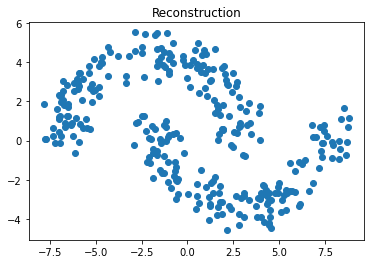

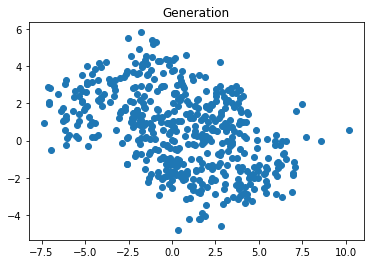

Epoch: 3800 loss: -0.5154 recon_loss: -5.3778 kl_loss: 4.8625 avg mean: -0.0288 avg std: 0.0131


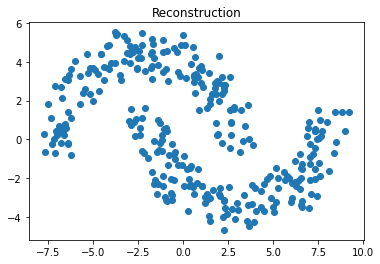

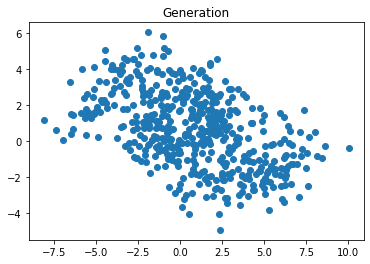

Epoch: 4000 loss: -0.6096 recon_loss: -5.6660 kl_loss: 5.0564 avg mean: -0.0440 avg std: 0.0101


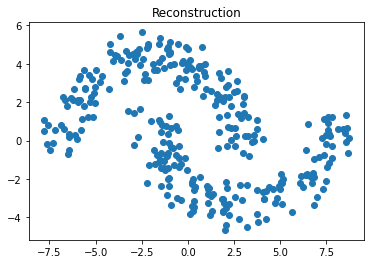

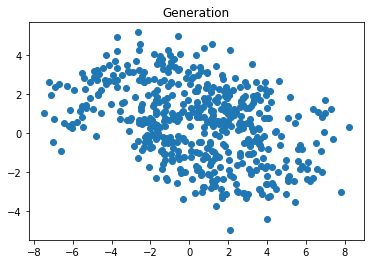

Epoch: 4200 loss: -0.7036 recon_loss: -5.9329 kl_loss: 5.2293 avg mean: 0.0002 avg std: 0.0087


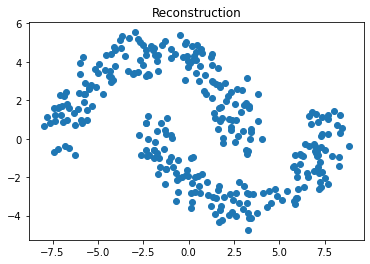

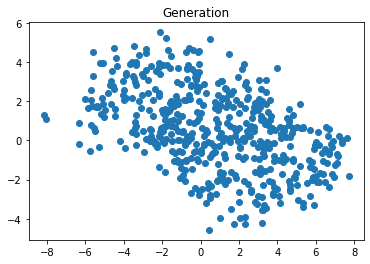

Epoch: 4400 loss: -0.8930 recon_loss: -6.2883 kl_loss: 5.3953 avg mean: 0.0286 avg std: 0.0074


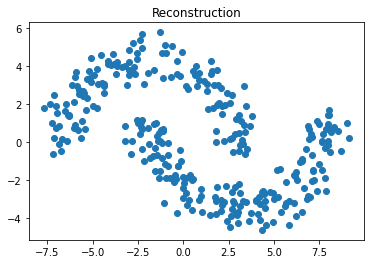

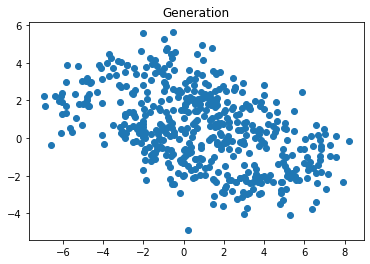

Epoch: 4600 loss: -1.0071 recon_loss: -6.5389 kl_loss: 5.5318 avg mean: -0.0477 avg std: 0.0064


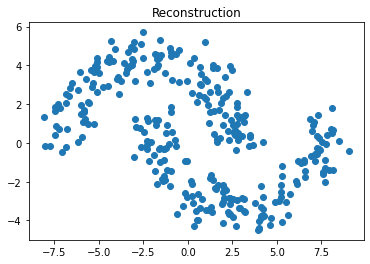

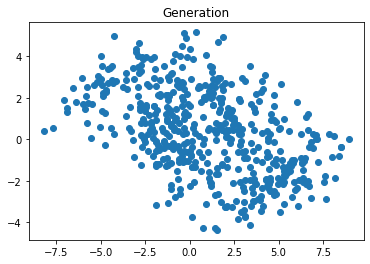

Epoch: 4800 loss: -0.8596 recon_loss: -6.5068 kl_loss: 5.6472 avg mean: 0.0617 avg std: 0.0057


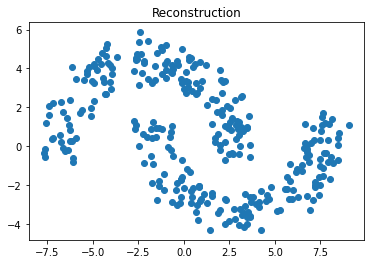

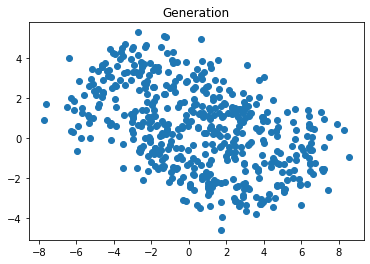

Epoch: 5000 loss: -0.7685 recon_loss: -6.4937 kl_loss: 5.7252 avg mean: -0.0161 avg std: 0.0053


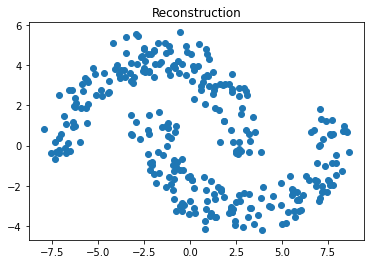

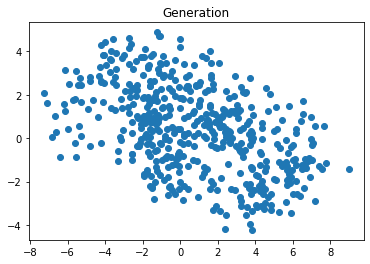

Epoch: 5200 loss: -1.0833 recon_loss: -6.8646 kl_loss: 5.7813 avg mean: 0.0413 avg std: 0.0052


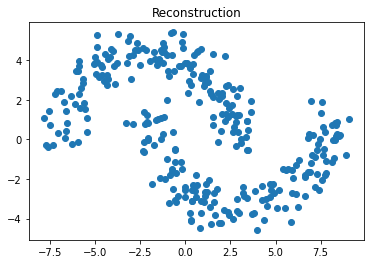

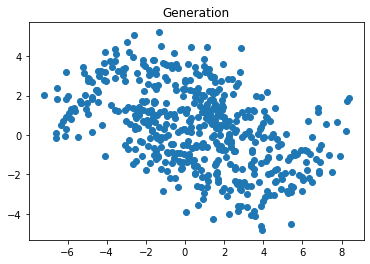

Epoch: 5400 loss: -0.8484 recon_loss: -6.6755 kl_loss: 5.8270 avg mean: 0.0355 avg std: 0.0049


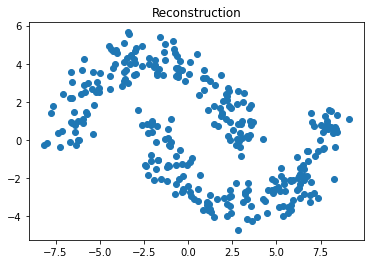

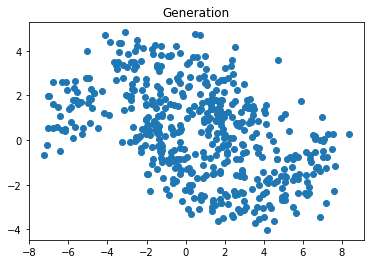

Epoch: 5600 loss: -1.2155 recon_loss: -7.0695 kl_loss: 5.8540 avg mean: -0.0370 avg std: 0.0046


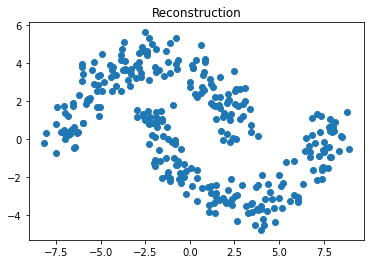

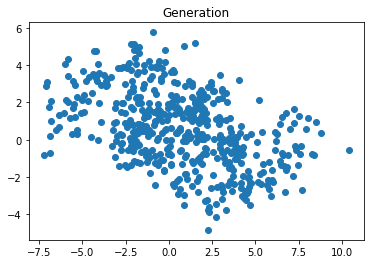

Epoch: 5800 loss: -1.2380 recon_loss: -7.1246 kl_loss: 5.8866 avg mean: -0.1093 avg std: 0.0047


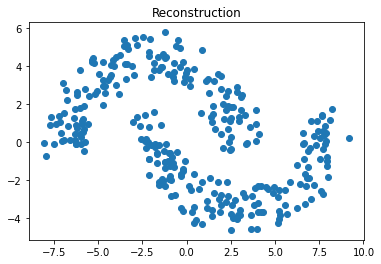

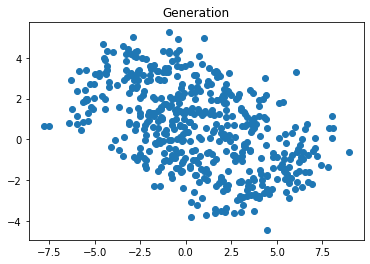

Epoch: 6000 loss: -0.9955 recon_loss: -6.9056 kl_loss: 5.9101 avg mean: 0.0109 avg std: 0.0044


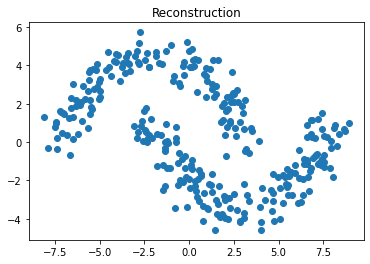

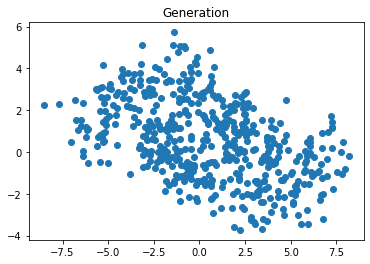

Epoch: 6200 loss: -0.9795 recon_loss: -6.9050 kl_loss: 5.9255 avg mean: -0.0134 avg std: 0.0043


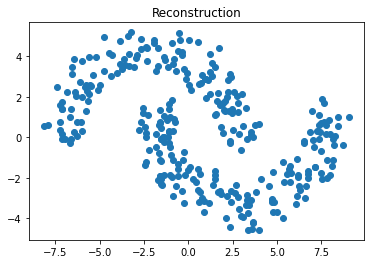

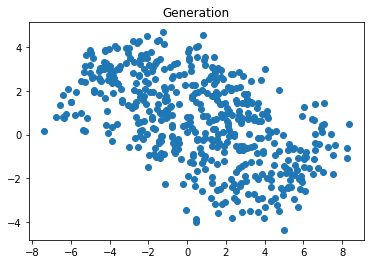

Epoch: 6400 loss: -1.1264 recon_loss: -7.0737 kl_loss: 5.9473 avg mean: 0.0447 avg std: 0.0044


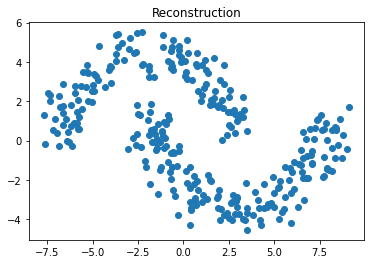

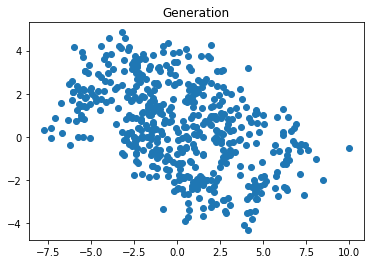

Epoch: 6600 loss: -1.3291 recon_loss: -7.2852 kl_loss: 5.9561 avg mean: -0.1018 avg std: 0.0043


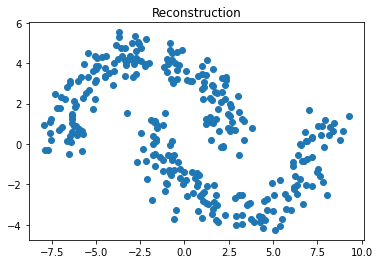

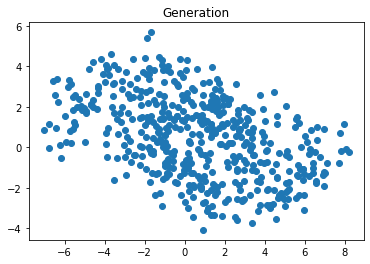

Epoch: 6800 loss: -1.3443 recon_loss: -7.3153 kl_loss: 5.9710 avg mean: -0.0262 avg std: 0.0041


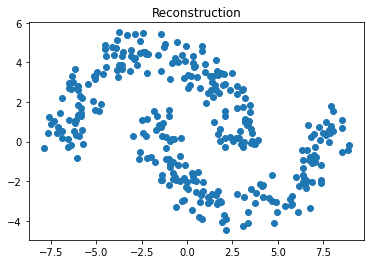

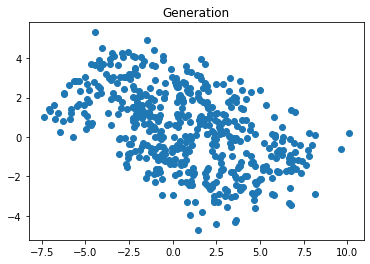

Epoch: 7000 loss: -1.2970 recon_loss: -7.2785 kl_loss: 5.9815 avg mean: -0.0313 avg std: 0.0042


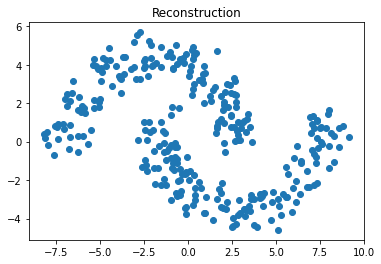

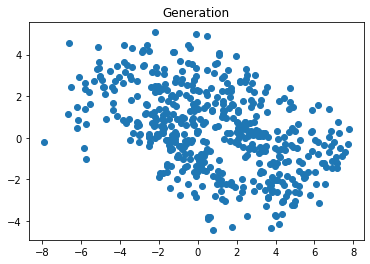

Epoch: 7200 loss: -1.2838 recon_loss: -7.2758 kl_loss: 5.9920 avg mean: 0.0513 avg std: 0.0044


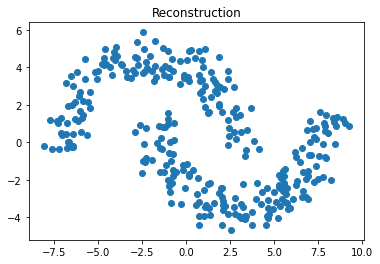

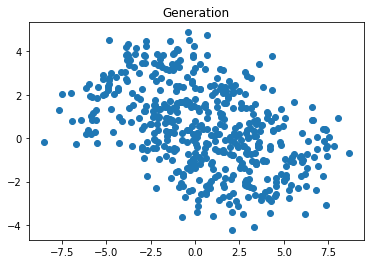

Epoch: 7400 loss: -1.4182 recon_loss: -7.4226 kl_loss: 6.0044 avg mean: 0.0475 avg std: 0.0042


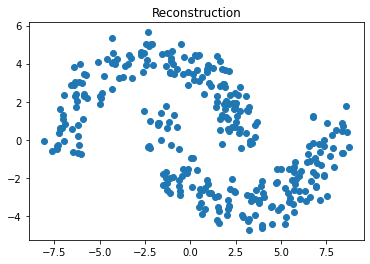

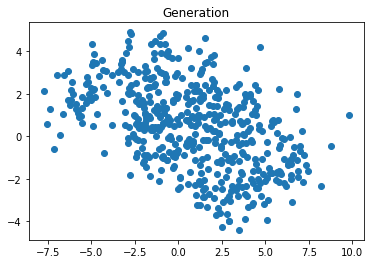

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

Text(0.5, 1.0, 'Data in latent space')

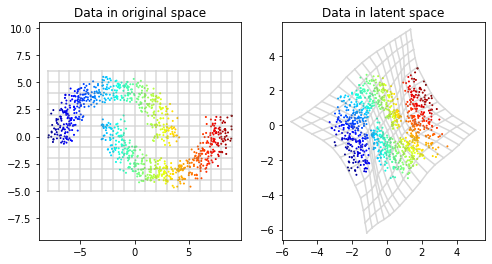

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")
vae.to(device)
vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid

enc_grid = vae.encode(torch.from_numpy(grid).float().to(device))[1]
enc_data = vae.encode(torch.from_numpy(data).float().to(device))[1]
enc_grid = enc_grid.detach().cpu().numpy()
enc_data = enc_data.detach().cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

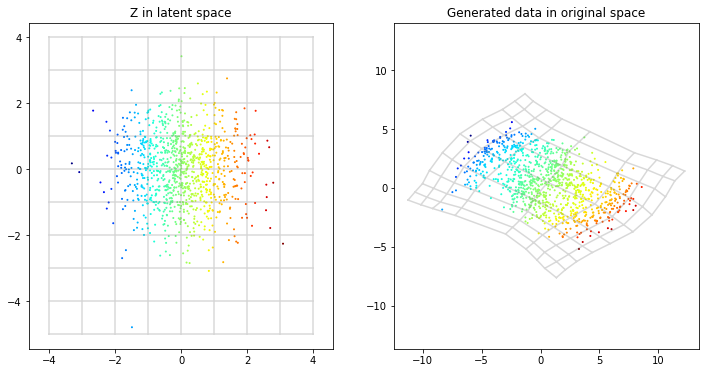

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = vae.decode(latent_samples.to(device))[0]
grid_gen = vae.decode(torch.from_numpy(latent_grid).float().to(device))[0]

x_gen = x_gen.detach().cpu().numpy()
grid_gen = grid_gen.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


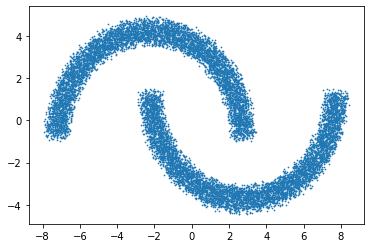

In [ ]:
moons = generate_moons(width=0.5)
moons_dl = InMemDataLoader([moons], batch_size=2048, shuffle=True)
moons_dl.to(device)
plt.scatter(moons[:, 0], moons[:, 1], s=0.5)

Epoch: 0 loss: -1.4939 recon_loss: -7.4961 kl_loss: 6.0022 avg mean: -0.1395 avg std: 0.0039


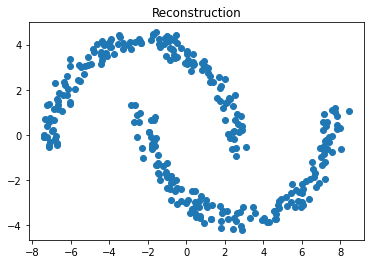

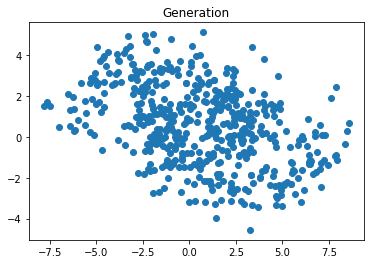

Epoch: 200 loss: -1.2021 recon_loss: -7.1795 kl_loss: 5.9774 avg mean: -0.1536 avg std: 0.0043


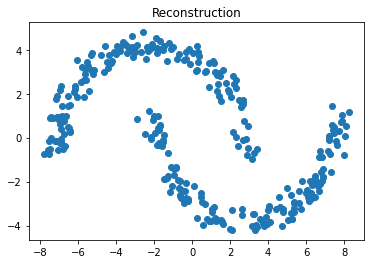

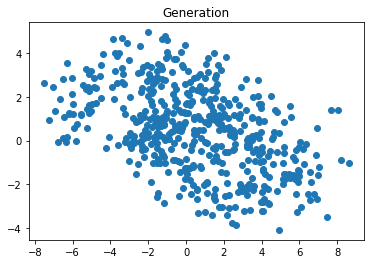

Epoch: 400 loss: -1.3886 recon_loss: -7.3932 kl_loss: 6.0046 avg mean: -0.0752 avg std: 0.0040


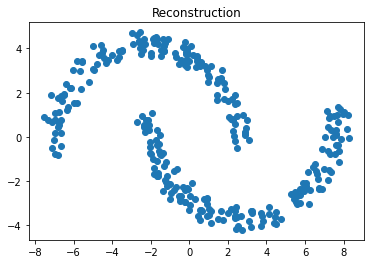

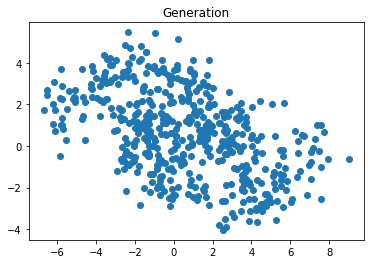

Epoch: 600 loss: -1.3850 recon_loss: -7.4201 kl_loss: 6.0351 avg mean: -0.0683 avg std: 0.0040


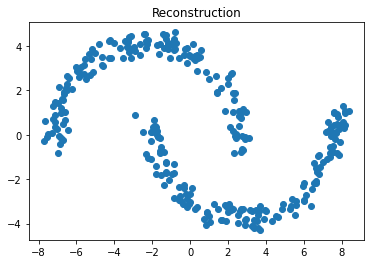

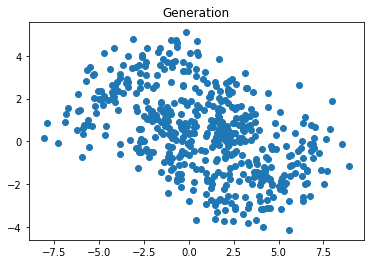

Epoch: 800 loss: -1.4470 recon_loss: -7.4999 kl_loss: 6.0528 avg mean: -0.1737 avg std: 0.0038


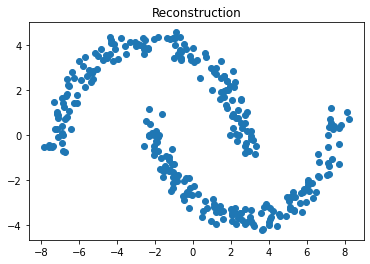

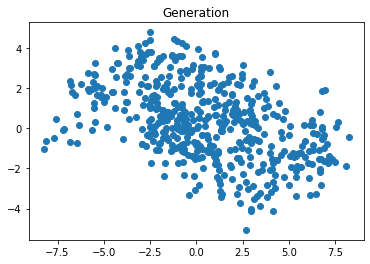

Epoch: 1000 loss: -1.7485 recon_loss: -7.8285 kl_loss: 6.0800 avg mean: -0.1264 avg std: 0.0037


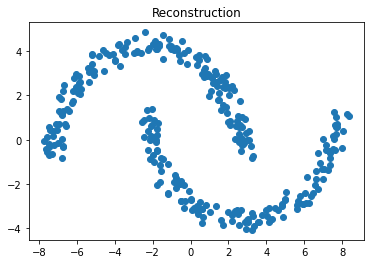

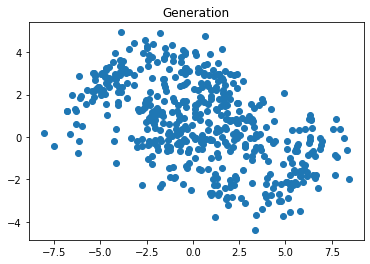

Epoch: 1200 loss: -1.6952 recon_loss: -7.7893 kl_loss: 6.0941 avg mean: -0.1177 avg std: 0.0038


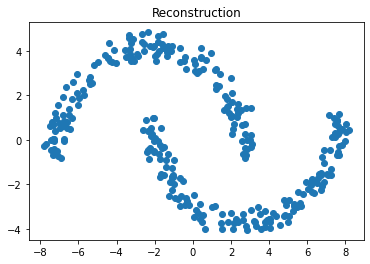

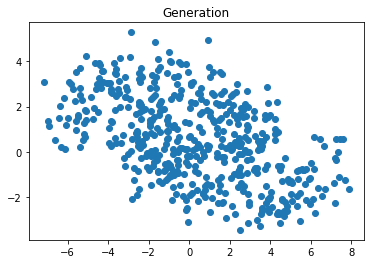

Epoch: 1400 loss: -1.7531 recon_loss: -7.8641 kl_loss: 6.1110 avg mean: -0.1612 avg std: 0.0037


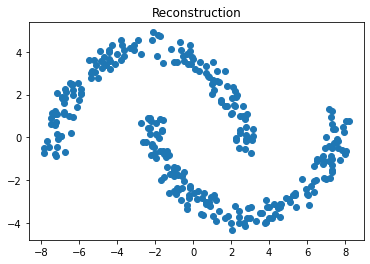

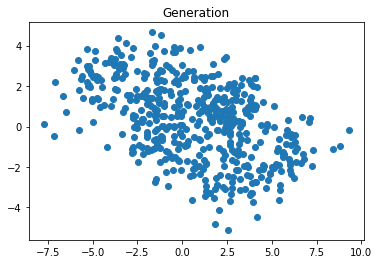

Epoch: 1600 loss: -1.5179 recon_loss: -7.6417 kl_loss: 6.1238 avg mean: -0.1231 avg std: 0.0037


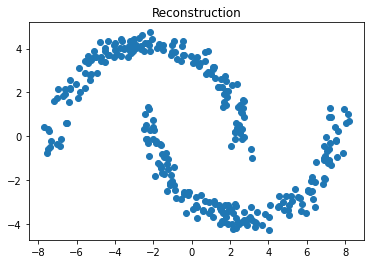

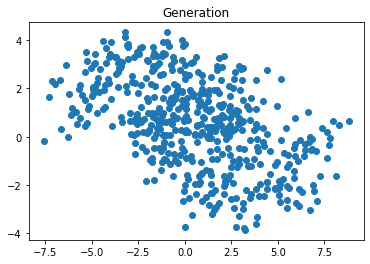

Epoch: 1800 loss: -1.3323 recon_loss: -7.4629 kl_loss: 6.1306 avg mean: -0.0256 avg std: 0.0037


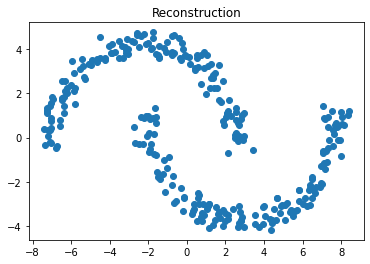

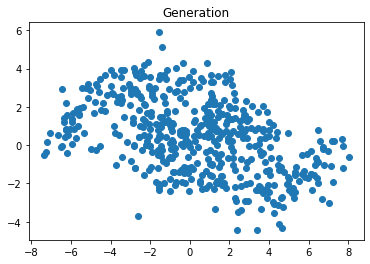

Epoch: 2000 loss: -1.8399 recon_loss: -7.9793 kl_loss: 6.1394 avg mean: -0.2083 avg std: 0.0037


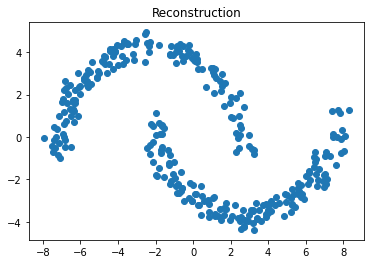

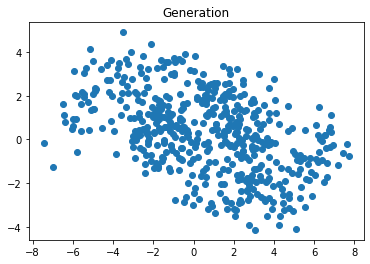

Epoch: 2200 loss: -1.7710 recon_loss: -7.9232 kl_loss: 6.1523 avg mean: -0.1646 avg std: 0.0036


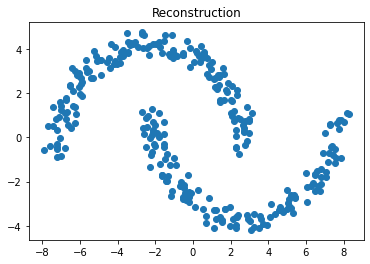

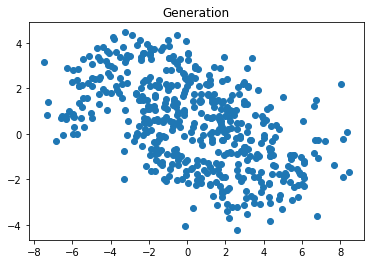

Epoch: 2400 loss: -1.8993 recon_loss: -8.0549 kl_loss: 6.1556 avg mean: -0.1497 avg std: 0.0037


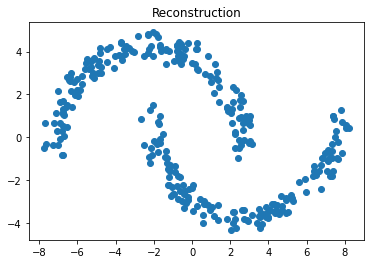

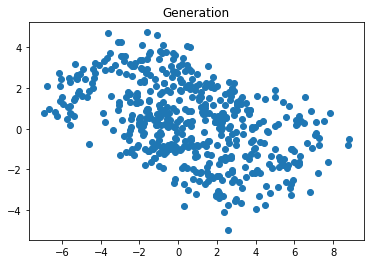

Epoch: 2600 loss: -1.7649 recon_loss: -7.9284 kl_loss: 6.1636 avg mean: -0.1440 avg std: 0.0035


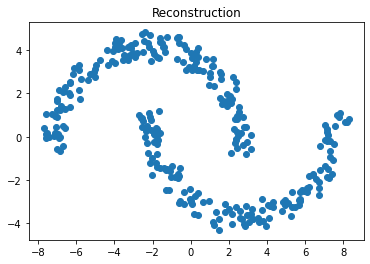

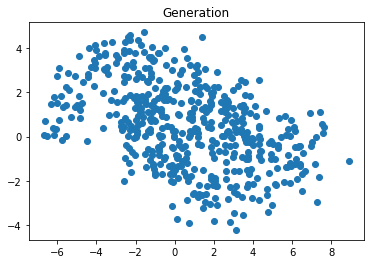

Epoch: 2800 loss: -1.6680 recon_loss: -7.8332 kl_loss: 6.1652 avg mean: -0.0749 avg std: 0.0036


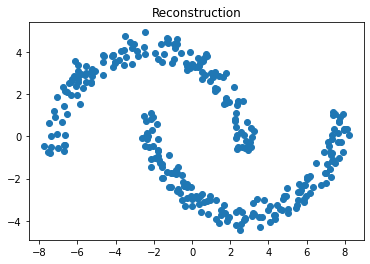

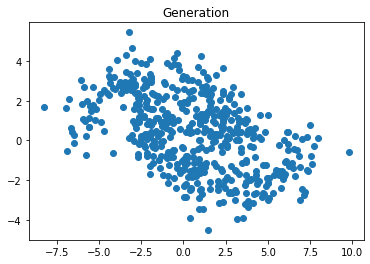

Epoch: 3000 loss: -1.7795 recon_loss: -7.9522 kl_loss: 6.1727 avg mean: -0.1280 avg std: 0.0035


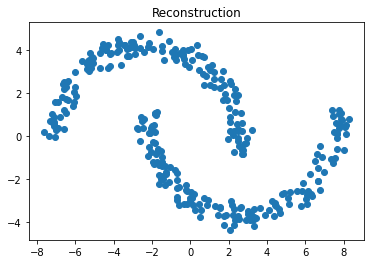

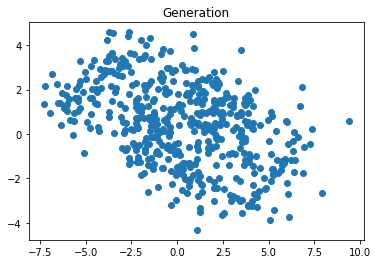

Epoch: 3200 loss: -1.5534 recon_loss: -7.7343 kl_loss: 6.1809 avg mean: -0.1376 avg std: 0.0035


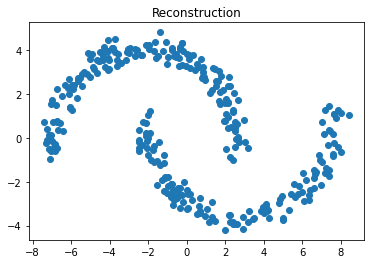

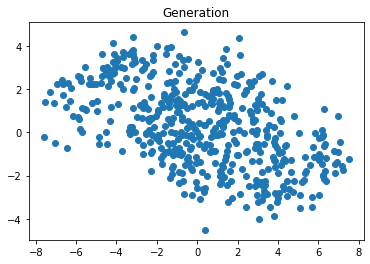

Epoch: 3400 loss: -1.6280 recon_loss: -7.8132 kl_loss: 6.1852 avg mean: -0.1143 avg std: 0.0034


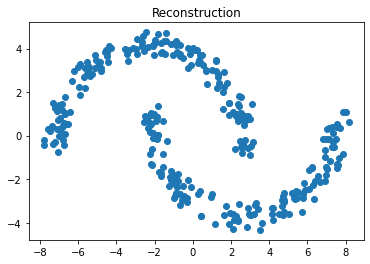

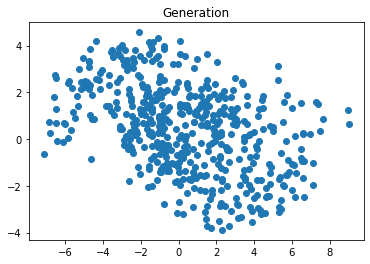

Epoch: 3600 loss: -1.8652 recon_loss: -8.0546 kl_loss: 6.1894 avg mean: -0.1071 avg std: 0.0035


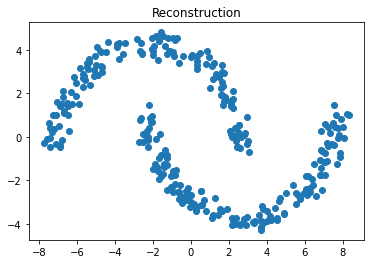

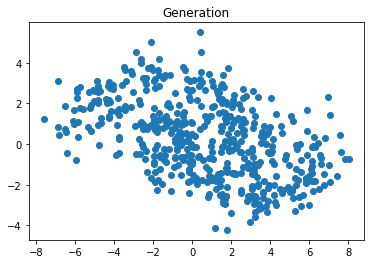

Epoch: 3800 loss: -1.4572 recon_loss: -7.6498 kl_loss: 6.1925 avg mean: -0.0055 avg std: 0.0034


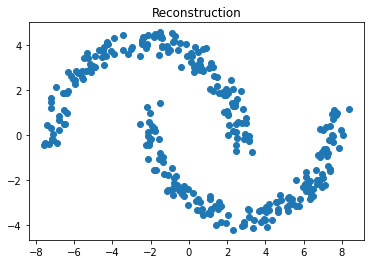

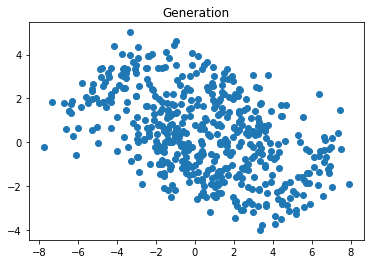

Epoch: 4000 loss: -1.8521 recon_loss: -8.0479 kl_loss: 6.1958 avg mean: -0.0476 avg std: 0.0035


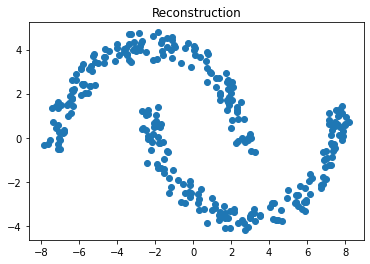

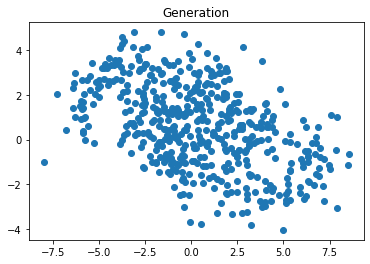

Epoch: 4200 loss: -1.7287 recon_loss: -7.9258 kl_loss: 6.1971 avg mean: -0.0981 avg std: 0.0035


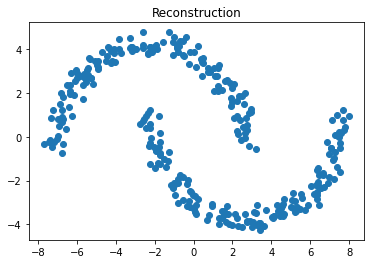

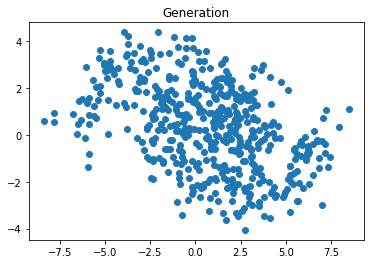

Epoch: 4400 loss: -1.8485 recon_loss: -8.0492 kl_loss: 6.2007 avg mean: -0.1365 avg std: 0.0034


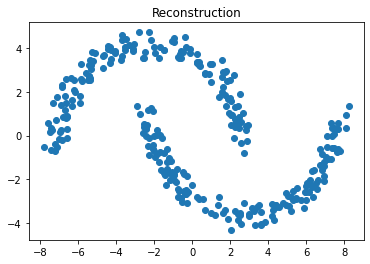

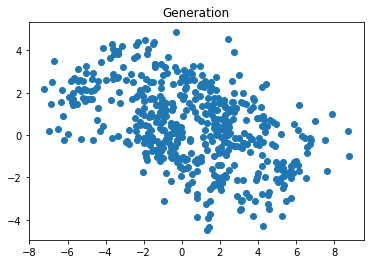

Epoch: 4600 loss: -1.1706 recon_loss: -7.3793 kl_loss: 6.2088 avg mean: -0.2099 avg std: 0.0034


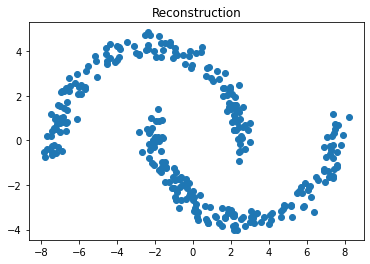

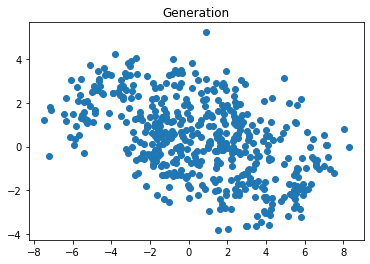

Epoch: 4800 loss: -1.6525 recon_loss: -7.8627 kl_loss: 6.2102 avg mean: -0.0269 avg std: 0.0034


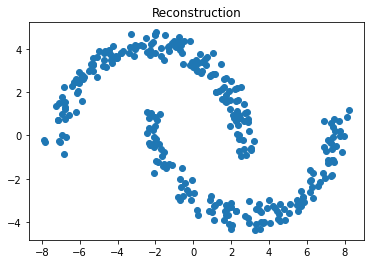

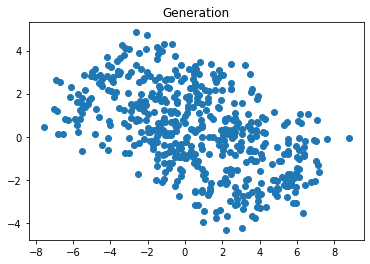

Epoch: 5000 loss: -1.6286 recon_loss: -7.8389 kl_loss: 6.2104 avg mean: -0.1470 avg std: 0.0035


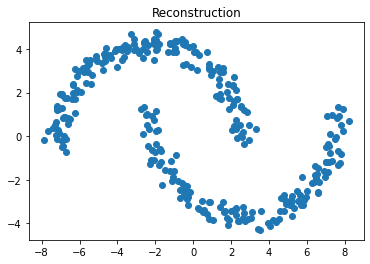

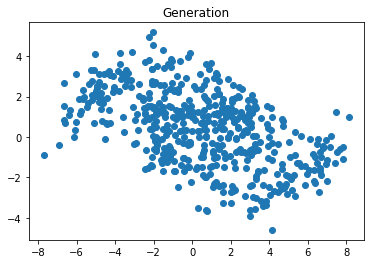

Epoch: 5200 loss: -1.8846 recon_loss: -8.1020 kl_loss: 6.2174 avg mean: -0.0965 avg std: 0.0035


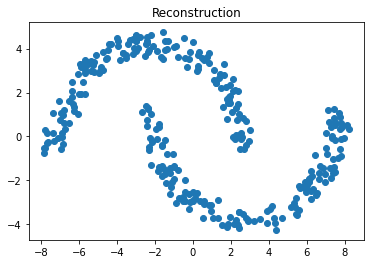

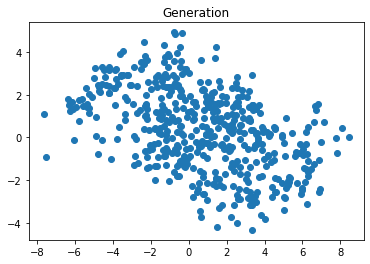

Epoch: 5400 loss: -1.6767 recon_loss: -7.8977 kl_loss: 6.2210 avg mean: -0.0986 avg std: 0.0033


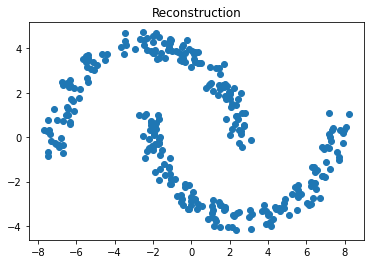

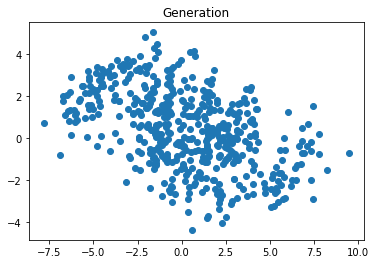

Epoch: 5600 loss: -1.9579 recon_loss: -8.1821 kl_loss: 6.2242 avg mean: -0.1090 avg std: 0.0035


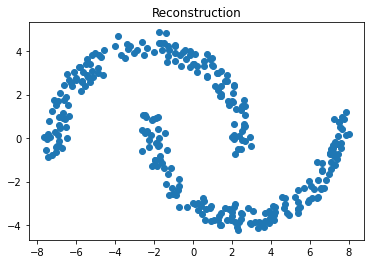

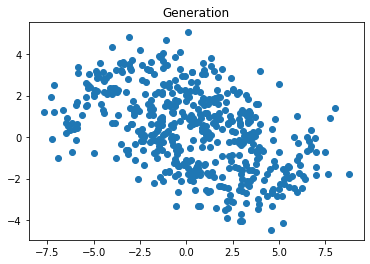

Epoch: 5800 loss: -1.1753 recon_loss: -7.3987 kl_loss: 6.2234 avg mean: -0.0156 avg std: 0.0033


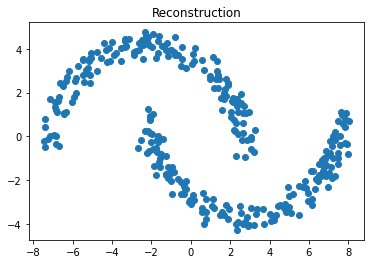

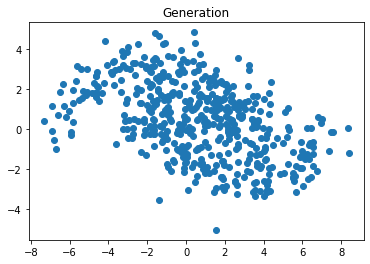

Epoch: 6000 loss: -1.8612 recon_loss: -8.0891 kl_loss: 6.2279 avg mean: -0.1631 avg std: 0.0034


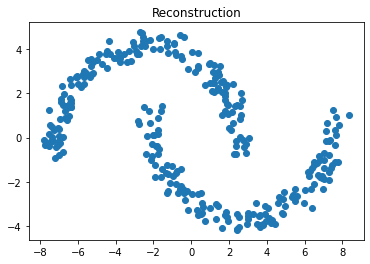

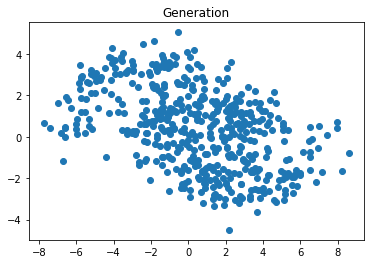

Epoch: 6200 loss: -1.9666 recon_loss: -8.1949 kl_loss: 6.2283 avg mean: -0.0552 avg std: 0.0034


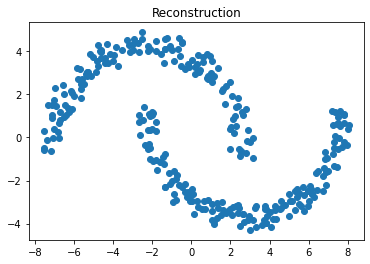

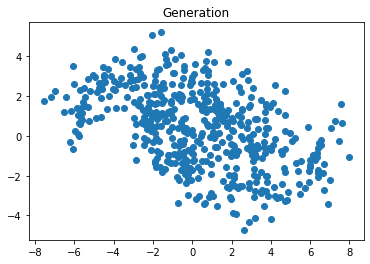

Epoch: 6400 loss: -1.9165 recon_loss: -8.1477 kl_loss: 6.2312 avg mean: -0.1565 avg std: 0.0034


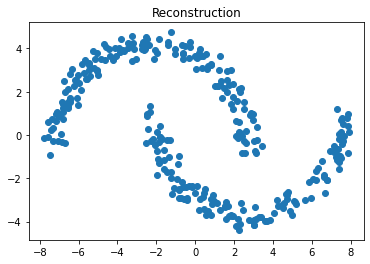

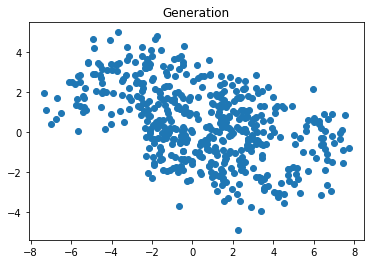

Epoch: 6600 loss: -1.9253 recon_loss: -8.1543 kl_loss: 6.2290 avg mean: -0.1771 avg std: 0.0034


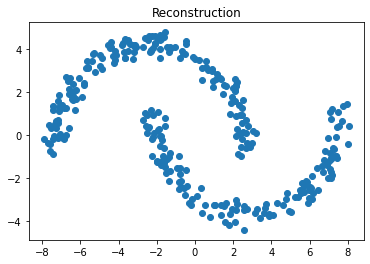

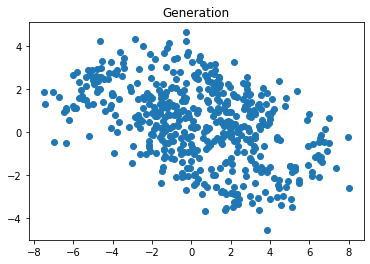

Epoch: 6800 loss: -1.6531 recon_loss: -7.8859 kl_loss: 6.2328 avg mean: -0.0111 avg std: 0.0034


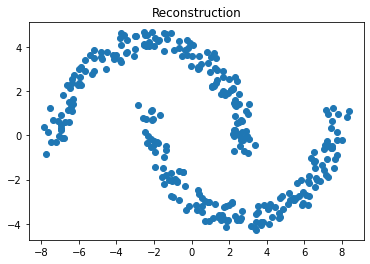

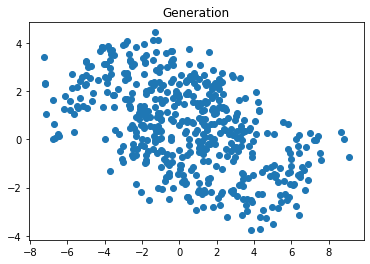

Epoch: 7000 loss: -1.8857 recon_loss: -8.1212 kl_loss: 6.2355 avg mean: -0.0439 avg std: 0.0034


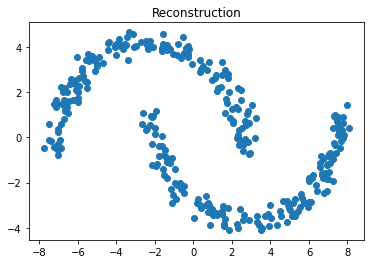

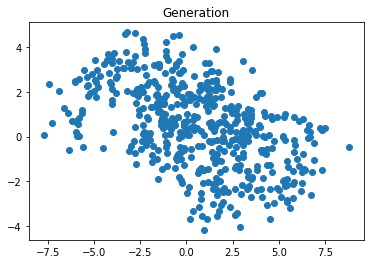

Epoch: 7200 loss: -1.8255 recon_loss: -8.0685 kl_loss: 6.2430 avg mean: -0.1080 avg std: 0.0034


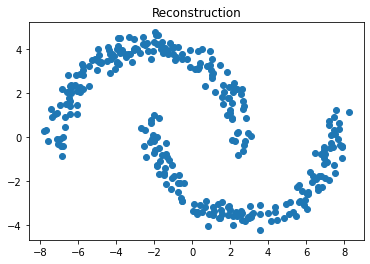

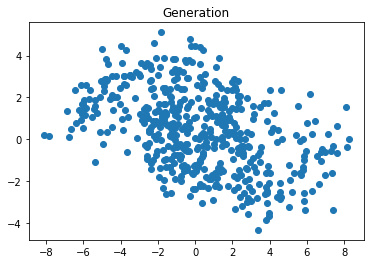

Epoch: 7400 loss: -1.5359 recon_loss: -7.7752 kl_loss: 6.2393 avg mean: -0.0808 avg std: 0.0034


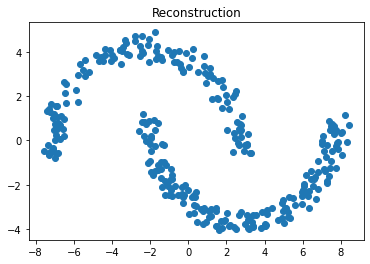

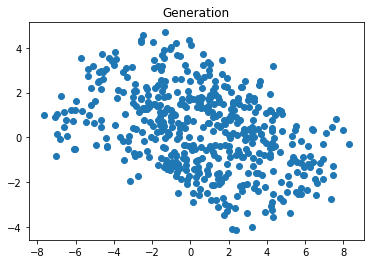

In [ ]:
# Please note: the model should converge faster!
for i in range(7500):
    recon_loss_acc = 0.0
    kl_acc = 0.0
    vae.train()
    for x, in moons_dl:
        x = x.float().to(device)

        x_mu, x_log_var, z_mu, z_log_var = vae(x)

        optimizer.zero_grad()
        recon_loss = reconstruction_loss(x_mu, x_log_var, x)
        kl = kl_loss(z_mu, z_log_var)
        loss = recon_loss + kl
        loss.backward()
        optimizer.step()

        recon_loss_acc += recon_loss.item() * len(x)
        kl_acc += kl.item() * len(x)

    if i % 200 == 0:
        print(
            f"Epoch: {i} loss: {(recon_loss_acc + kl_acc) / len(moons) :.4f} recon_loss: {recon_loss_acc / len(moons) :.4f} kl_loss: {kl_acc / len(moons) :.4f} avg mean: {z_mu.detach().mean() :.4f} avg std: {torch.exp(z_log_var.detach() / 2).mean() :.4f}"
        )
        vae.eval()
        with torch.no_grad():
            # Reconstruct data
            x_recon = torch.randn(x.shape).to(device) * torch.exp(x_log_var / 2) + x_mu
            x_recon = x_recon.cpu()

            plt.scatter(x_recon[:, 0], x_recon[:, 1])
            plt.title("Reconstruction")
            plt.show()

            # Generate new data
            z = torch.randn(500, z_dim).to(device)
            x_gen_mu, x_gen_log_var = vae.decode(z)
            x_gen = (
                torch.randn(z.shape[0], 2).to(device) * torch.exp(x_gen_log_var / 2)
                + x_gen_mu
            )
            x_gen = x_gen.cpu()

            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title("Generation")
            plt.show()

Text(0.5, 1.0, 'Data in latent space')

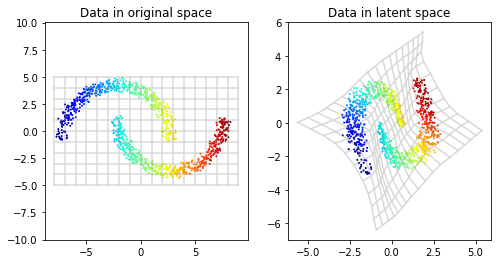

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")
vae.to(device)
vae.eval()

plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid

enc_grid = vae.encode(torch.from_numpy(grid).float().to(device))[1]
enc_data = vae.encode(torch.from_numpy(data).float().to(device))[1]
enc_grid = enc_grid.detach().cpu().numpy()
enc_data = enc_data.detach().cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")

Text(0.5, 1.0, 'Generated data in original space')

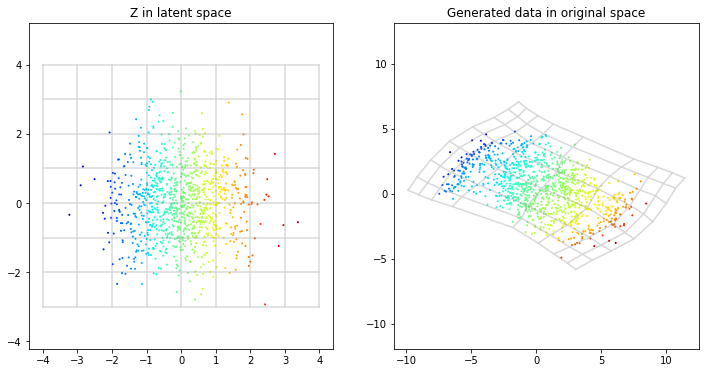

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

vae.eval()

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = vae.decode(latent_samples.to(device))[0]
grid_gen = vae.decode(torch.from_numpy(latent_grid).float().to(device))[0]

x_gen = x_gen.detach().cpu().numpy()
grid_gen = grid_gen.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Answers: 
Pierwsza wariancja pochodzi od stałej znajdujacej się przed wykładniczym wyrażeniem z e, a druga od wariancji w wykładniku e.

Drugi składnik negative log likelihood jest zawsze dodatni. Pierwszy może być dodatni gdy sigma jest mała. Całe wyrażenie może być ujemne, gdy sigma jest mała i drugie wyrażenie jest bliskie zeru.

## GAN

In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)
        

In [ ]:
# ? nn.BCELoss()

In [ ]:
# loss = nn.BCELoss()
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    # ret = loss(torch.ones_like(DG),DG)
    loss = -(torch.ones_like(DG) * torch.log2(DG+eps) + (1-torch.ones_like(DG)) * (torch.log2(1-DG+eps))).mean()
    return  0.5 * loss


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    real_loss = -(torch.ones_like(DR) * torch.log2(DR+eps) + (1-torch.ones_like(DR)) * (torch.log2(1-DR+eps))).mean()
    fake_loss = -(torch.ones_like(DG) * torch.log2(1 -DG+eps) + (1-torch.ones_like(DG)) * (torch.log2(DG+eps))).mean()
    total_loss = 0.5 * real_loss + 0.5 * fake_loss
    return total_loss



In [ ]:
z_dim = 2
hid_dim = 64
lr = 0.0007

G = Generator(in_dim=z_dim, hid_dim=hid_dim).to(device)
D = Discriminator(hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

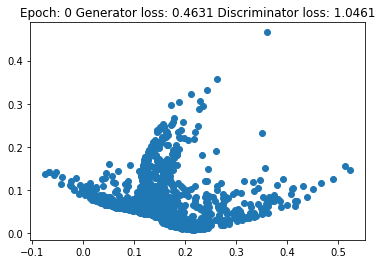

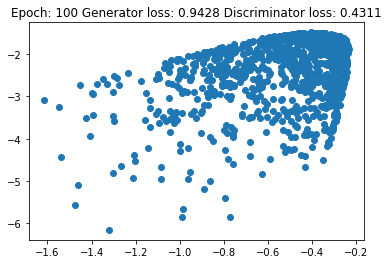

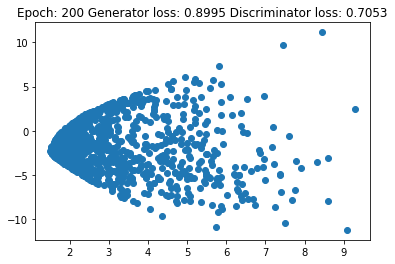

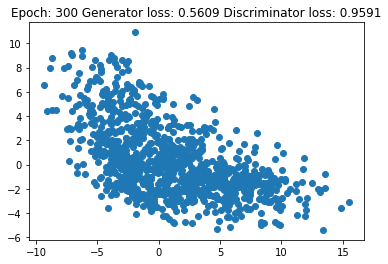

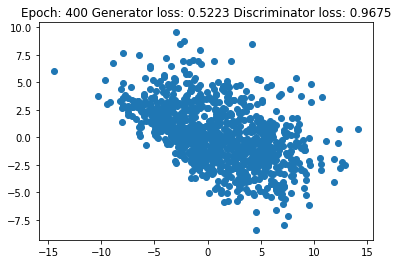

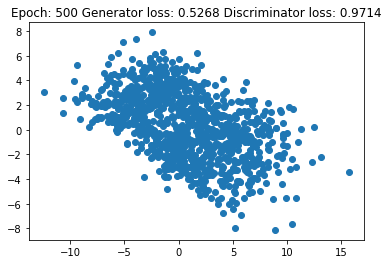

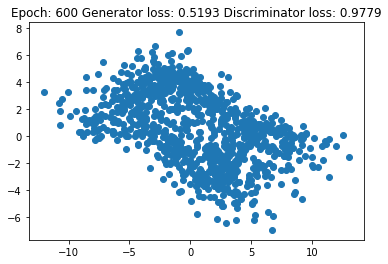

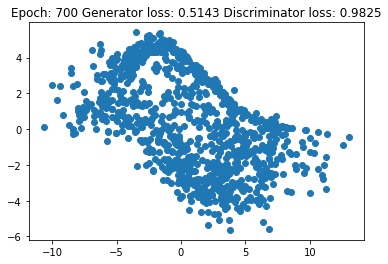

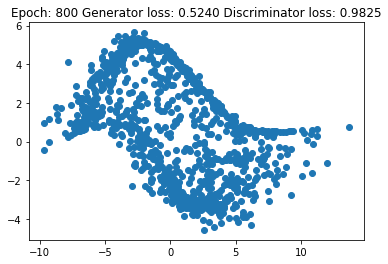

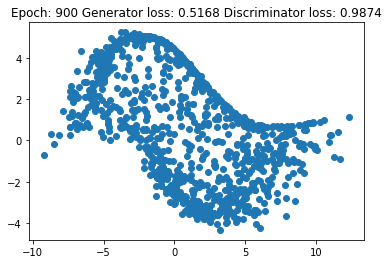

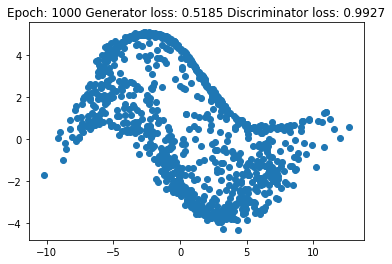

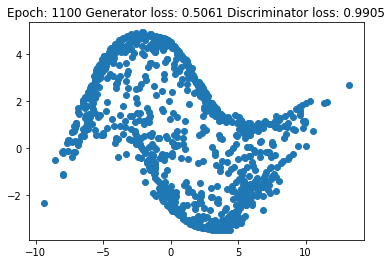

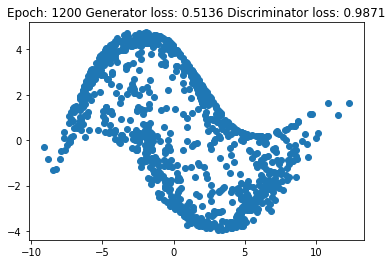

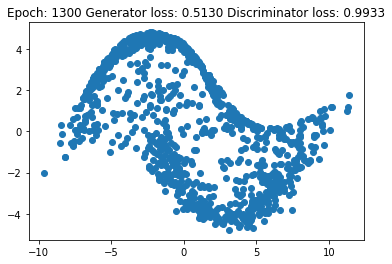

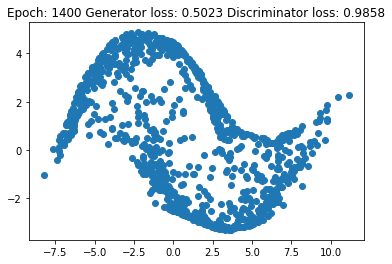

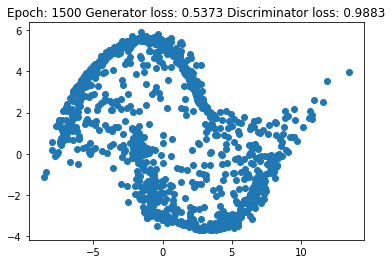

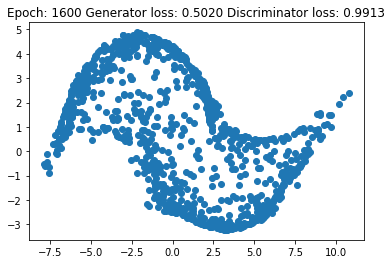

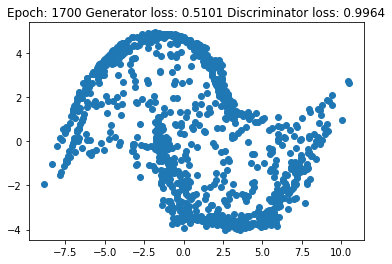

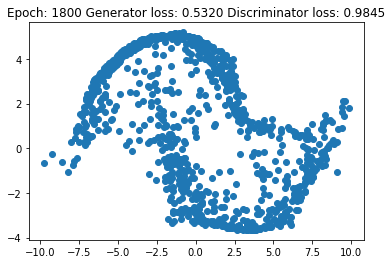

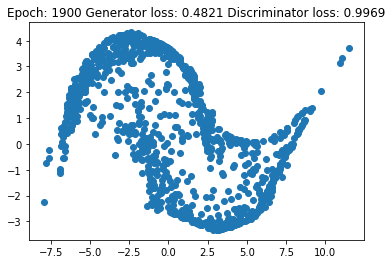

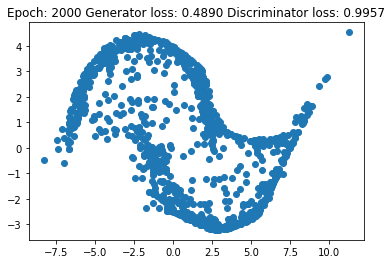

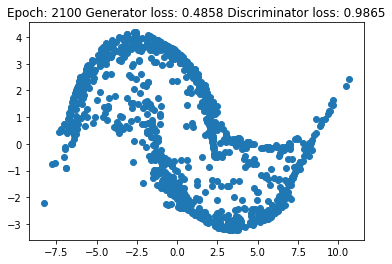

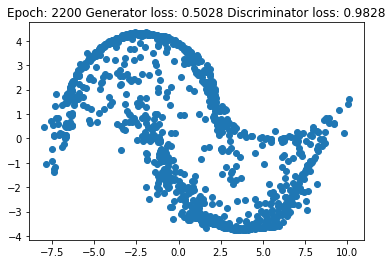

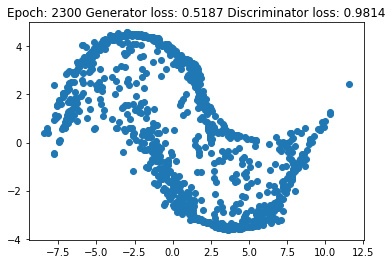

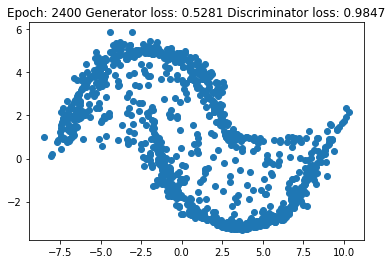

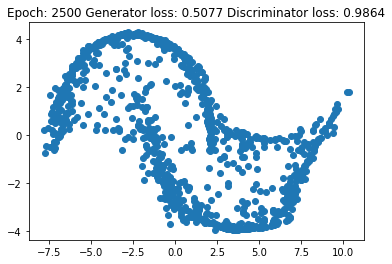

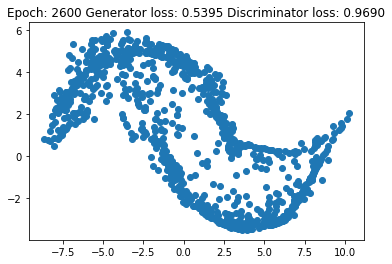

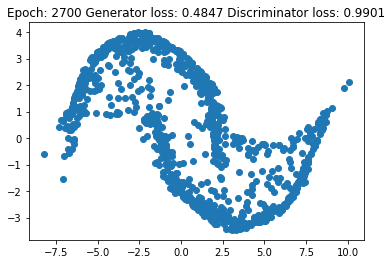

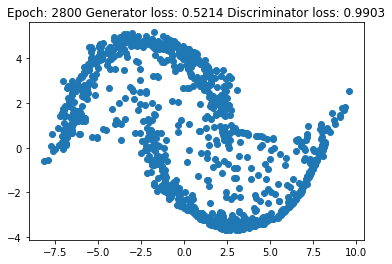

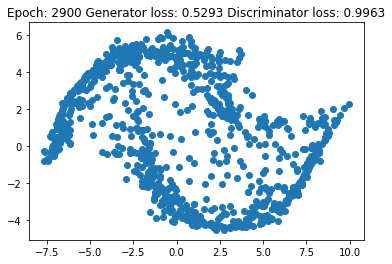

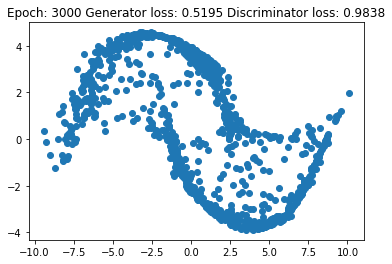

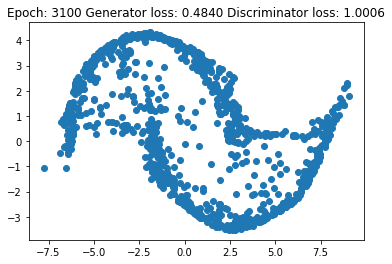

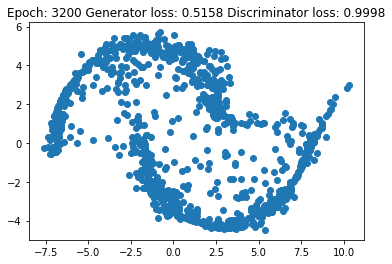

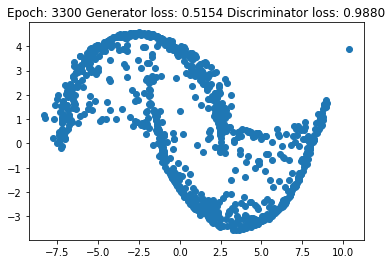

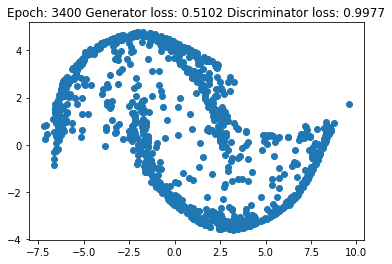

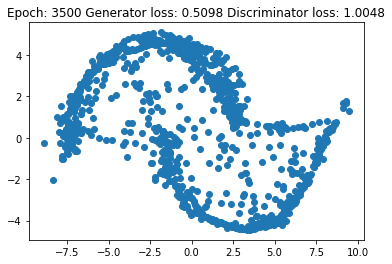

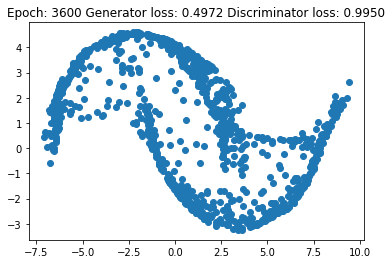

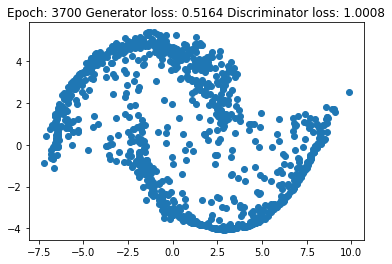

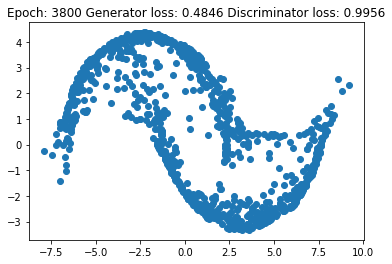

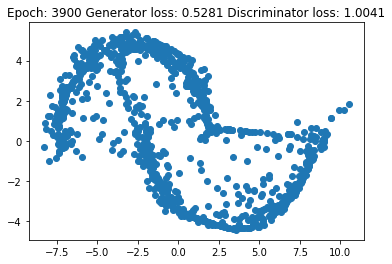

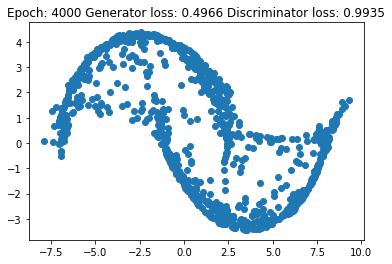

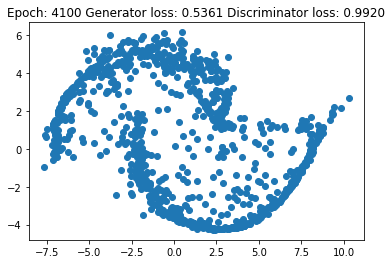

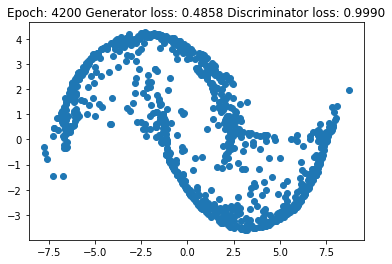

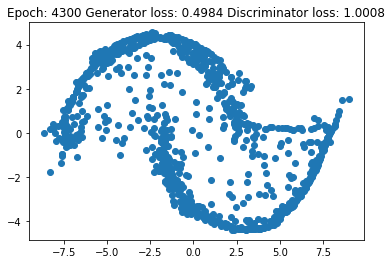

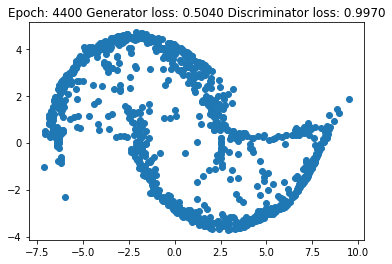

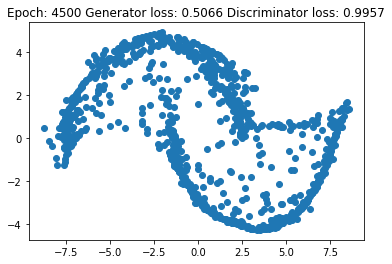

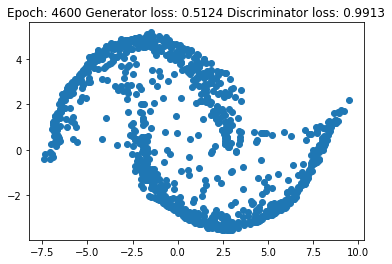

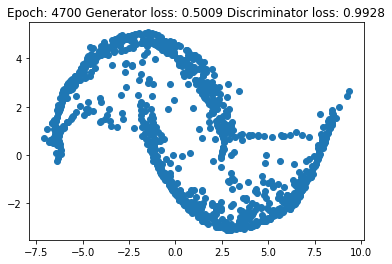

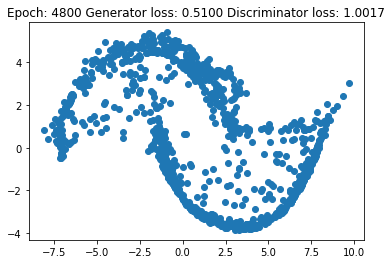

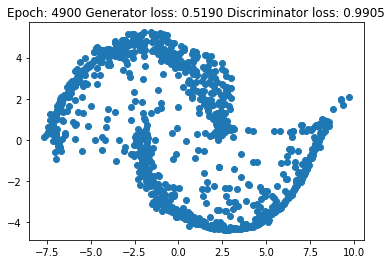

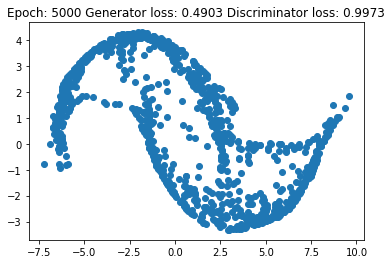

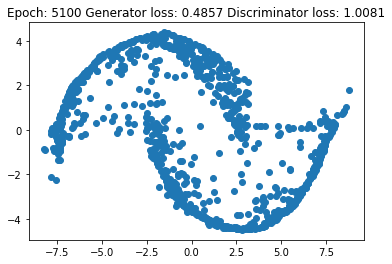

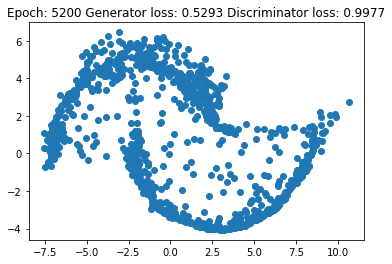

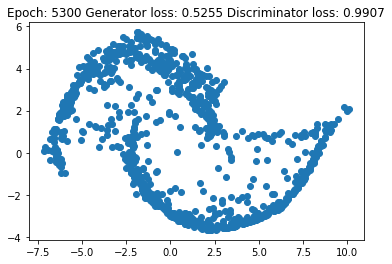

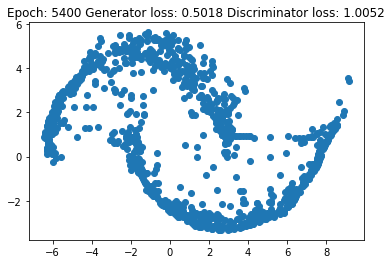

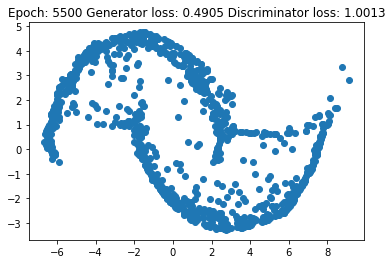

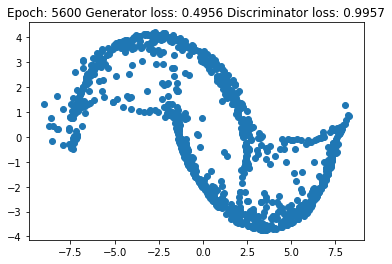

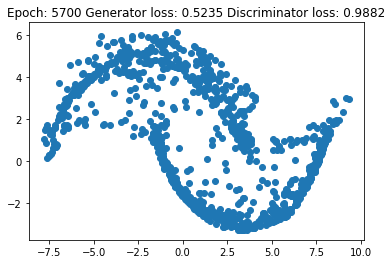

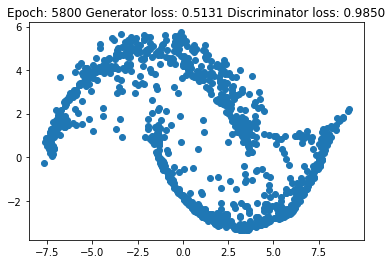

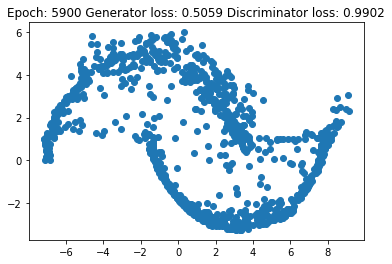

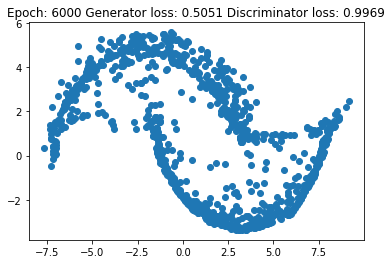

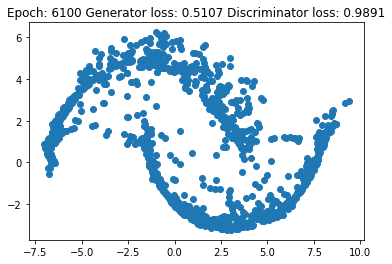

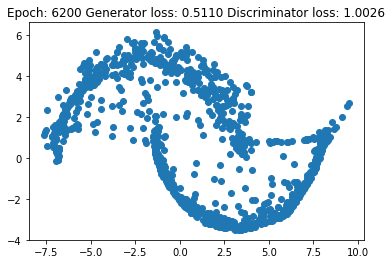

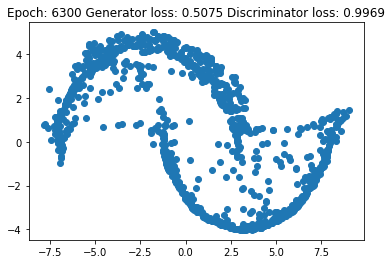

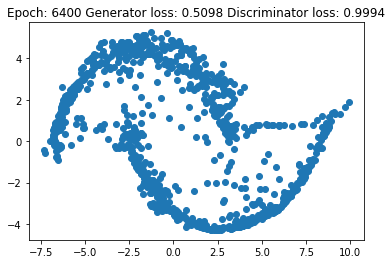

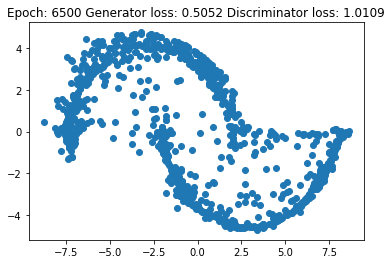

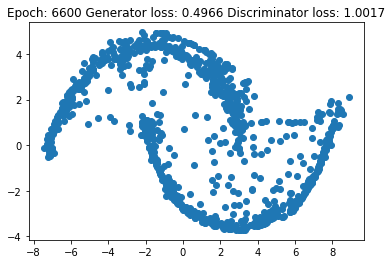

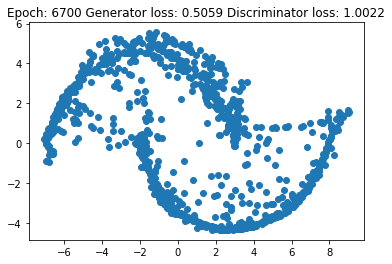

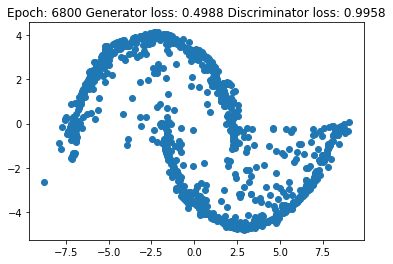

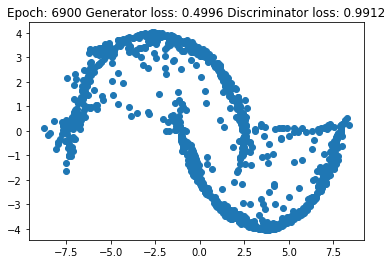

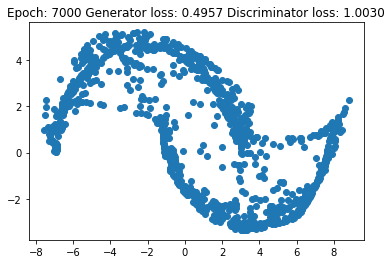

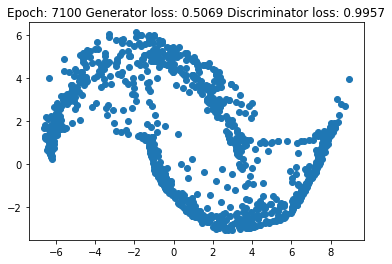

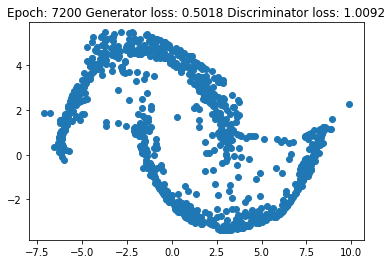

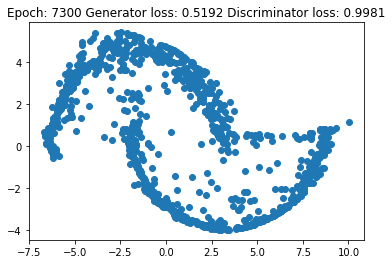

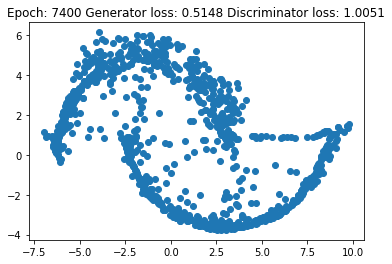

In [ ]:
for i in range(7500):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, in moons_dl:
        x = x.float().to(device)

        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 100 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            plt.scatter(x_gen[:, 0], x_gen[:, 1])
            plt.title(
                f"Epoch: {i} Generator loss: {G_loss_acc / len(moons) :.4f} Discriminator loss: {D_loss_acc / len(moons) :.4f}"
            )
            plt.show()

Text(0.5, 1.0, 'Generated data in original space')

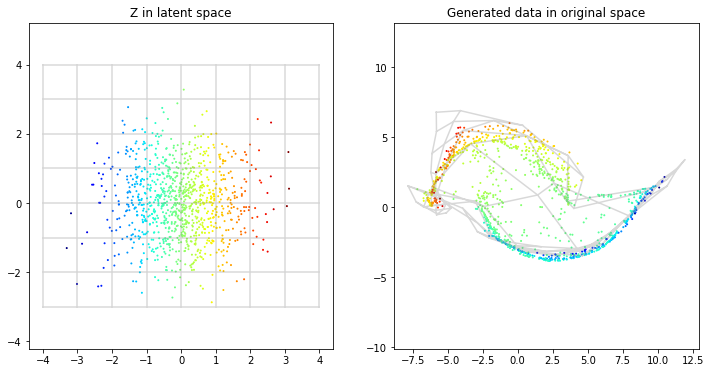

In [ ]:
latent_samples = torch.randn(1000, z_dim)

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

G.eval()
# TODO: compute the projection into data space of the latent saples and the grid

x_gen = G(latent_samples.to(device))
grid_gen = G(torch.from_numpy(latent_grid).float().to(device))

x_gen = x_gen.detach().cpu().numpy()
grid_gen = grid_gen.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## Answers 
Gan is concentrating more on some regions thats why generated photos like those which were shown on lecture look so good.

## Normalizing Flow

In [ ]:
? torch.cat

In [ ]:
class CouplingLayer(nn.Module):
    def __init__(self, idx, in_dim, hid_dim, out_dim):
        super(CouplingLayer, self).__init__()
        self.in_dim = in_dim // 2
        self.hid_dim = hid_dim
        self.out_dim = out_dim // 2
        self.odd = idx % 2 == 1

        self.s = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
            nn.Tanh(),
        )

        self.t = nn.Sequential(
            nn.Linear(self.in_dim, self.hid_dim),
            nn.ReLU(),
            nn.Linear(self.hid_dim, self.out_dim),
        )

    def forward(self, x, ldetJ):
        # Split x into two halves along dimension axis.
        x1, x2 = x[:, 0, None], x[:, 1, None]  # x1, x2 = TODO
        if self.odd:
            x1, x2 = x2, x1

        s = self.s(x1)
        t = self.t(x1)
        # Transform x2 using s and t.
        # x1 = x1
        x2 = x2*s + t

        if self.odd:
            x1, x2 = x2, x1
        # Add log determinant of the Jacobian
        # 1e-6
        ldetJ += s.abs().log()
        # ldetJ += x2 * x1

        return torch.cat([x1, x2], dim=1), ldetJ

    def invert(self, z):
        z1, z2 = z[:, 0, None], z[:, 1, None]
        if self.odd:
            z1, z2 = z2, z1

        s = self.s(z1)
        t = self.t(z1)
        # Invert the transformation of x2 from the forward step.
        # z1 = z1
        z2 = (z2 - t)/s

        if self.odd:
            z1, z2 = z2, z1

        return torch.cat([z1, z2], dim=1)


class RealNVP(nn.Module):
    def __init__(self, n_coupling_layers=4, in_dim=2, hid_dim=128, out_dim=2):
        super(RealNVP, self).__init__()
        assert n_coupling_layers % 2 == 0
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.coupling_layers = nn.ModuleList(
            [
                CouplingLayer(i, in_dim, hid_dim, out_dim)
                for i in range(n_coupling_layers)
            ]
        )

    def forward(self, x):
        ldetJ = 0.0
        for layer in self.coupling_layers:
            x, ldetJ = layer(x, ldetJ)
        return x, ldetJ

    def invert(self, z):
        for layer in reversed(self.coupling_layers):
            z = layer.invert(z)
        return z

In [ ]:
# ? log_prob()
? prior_z.log_prob()

In [ ]:
# loss = nn.NLLLoss()
def nll_loss(z, ldetJ, prior_z):
    # Define negative log-likelihood loss for change of variable formula.
    # Hint: use prior_z.log_prob().
    # ?prior_z.log_prob()
    # print(prior_z.log_prob(z))
    # print(ldetJ)
    # print(z.shape)
    # print(ldetJ.shape)
    return  -(prior_z.log_prob(z) + ldetJ).mean()


In [ ]:
n_coupling_layers = 6
hid_dim = 64
lr = 0.003

flow = RealNVP(n_coupling_layers=n_coupling_layers, hid_dim=hid_dim).to(device)
optimizer = optim.Adam(flow.parameters(), lr=lr)
prior_z = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

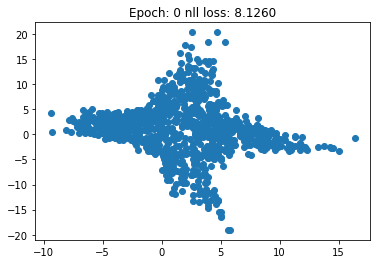

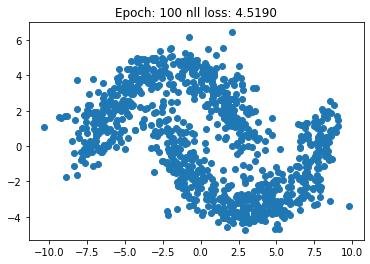

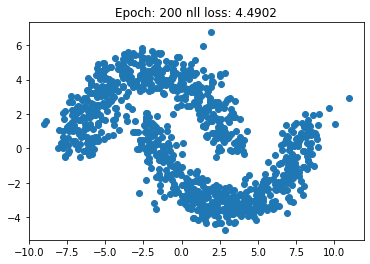

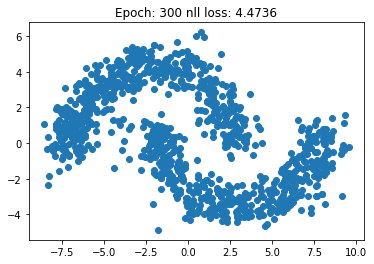

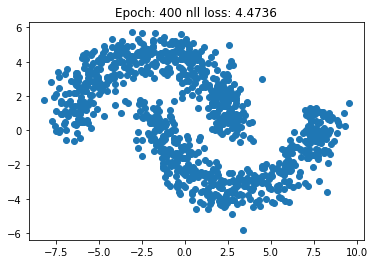

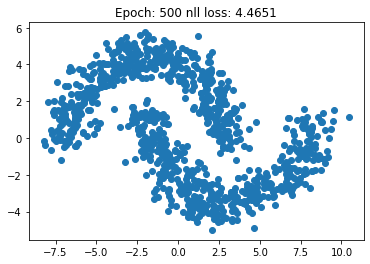

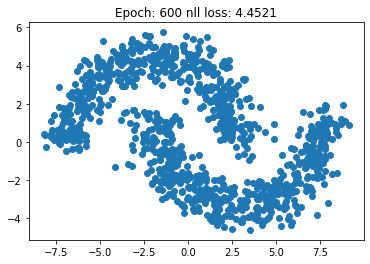

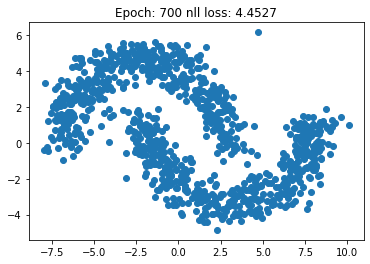

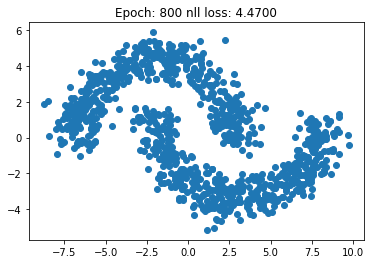

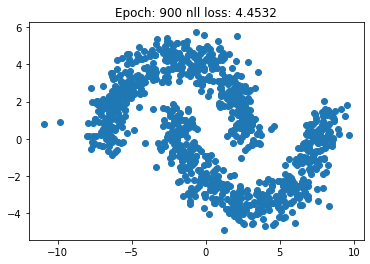

In [ ]:
for i in range(1000):
    loss_acc = 0.0
    flow.train()
    for x, in moons_dl:
        x = x.float().to(device)
        # dequantization - add a little random noise
        x += torch.rand(x.shape, device=device) / 1e2
        z, ldetJ = flow(x)

        loss = nll_loss(z, ldetJ, prior_z)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_acc += loss.item() * len(x)

    if i % 100 == 0:
        flow.eval()
        with torch.no_grad():
            z = prior_z.sample((1000,))
            x = flow.invert(z).cpu()
            plt.scatter(x[:, 0], x[:, 1])
            plt.title(f"Epoch: {i} nll loss: {loss_acc / len(moons) :.4f}")
            plt.show()

(-5.0, 5.0)

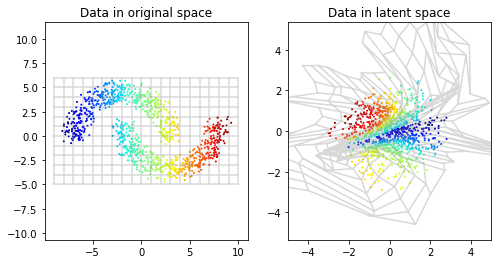

In [ ]:
data = np.array(moons)[np.random.permutation(moons.shape[0])[:1000]]
grid = get_grid(data)

data_colors = (data[:, 0] - min(data[:, 0])) / (max(data[:, 0]) - min(data[:, 0]))
data_colors = plt.cm.jet(data_colors)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)

plt.plot(grid[:, 0], grid[:, 1], color="gray", alpha=0.3)
plt.scatter(data[:, 0], data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in original space")


plt.subplot(1, 2, 2)

# TODO: compute the latent encoding of the data nd the grid
enc_grid = flow(torch.from_numpy(grid).float().to(device))[0]
enc_data= flow(torch.from_numpy(data).float().to(device))[0]

enc_grid = enc_grid.detach().cpu().numpy()
enc_data = enc_data.detach().cpu().numpy()

plt.plot(enc_grid[:, 0], enc_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(enc_data[:, 0], enc_data[:, 1], color=data_colors, s=1.0)
_ = plt.axis("equal")
plt.title("Data in latent space")
plt.xlim(-5, 5)
plt.ylim(-5, 5)

Text(0.5, 1.0, 'Generated data in original space')

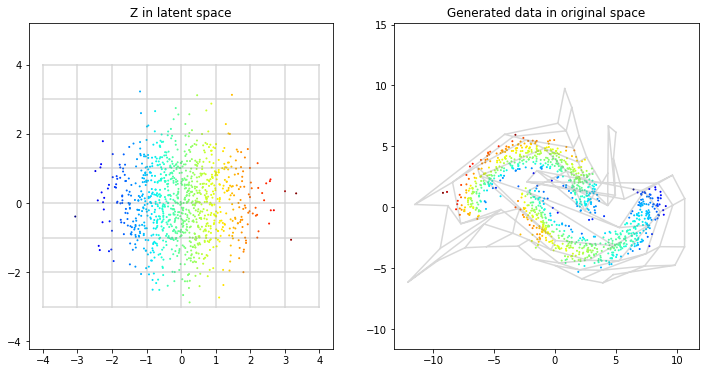

In [ ]:
latent_samples = prior_z.sample((1000,)).cpu()

latent_colors = (latent_samples[:, 0] - min(latent_samples[:, 0])) / (
    max(latent_samples[:, 0]) - min(latent_samples[:, 0])
)
latent_colors = plt.cm.jet(latent_colors.numpy())

latent_grid = get_grid(latent_samples.numpy())

# TODO: compute the projection into data space of the latent saples and the grid
x_gen = flow.invert(latent_samples.float().to(device))
grid_gen = flow.invert(torch.from_numpy(latent_grid).float().to(device))

x_gen = x_gen.detach().cpu().numpy()
grid_gen = grid_gen.detach().cpu().numpy()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(latent_grid[:, 0], latent_grid[:, 1], color="gray", alpha=0.3)
plt.scatter(latent_samples[:, 0], latent_samples[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Z in latent space")

plt.subplot(1, 2, 2)

plt.plot(grid_gen[:, 0], grid_gen[:, 1], color="gray", alpha=0.3)
plt.scatter(x_gen[:, 0], x_gen[:, 1], color=latent_colors, s=1)
_ = plt.axis("equal")
plt.title("Generated data in original space")

## MNIST

In [ ]:

import os
import time

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from tqdm.auto import tqdm

import torch
import torch.nn.functional as F
import torchvision.datasets
from torch import nn

In [ ]:
class InMemDataLoader(object):
    """
    A data loader that keeps all data in CPU or GPU memory.
    """

    __initialized = False

    def __init__(
        self,
        dataset,
        batch_size=1,
        shuffle=False,
        sampler=None,
        batch_sampler=None,
        drop_last=False,
    ):
        """A torch dataloader that fetches data from memory."""
        batches = []
        for i in tqdm(range(len(dataset))):
            batch = [torch.tensor(t) for t in dataset[i]]
            batches.append(batch)
        tensors = [torch.stack(ts) for ts in zip(*batches)]
        dataset = torch.utils.data.TensorDataset(*tensors)
        self.dataset = dataset
        self.batch_size = batch_size
        self.drop_last = drop_last

        if batch_sampler is not None:
            if batch_size > 1 or shuffle or sampler is not None or drop_last:
                raise ValueError(
                    "batch_sampler option is mutually exclusive "
                    "with batch_size, shuffle, sampler, and "
                    "drop_last"
                )
            self.batch_size = None
            self.drop_last = None

        if sampler is not None and shuffle:
            raise ValueError("sampler option is mutually exclusive with " "shuffle")

        if batch_sampler is None:
            if sampler is None:
                if shuffle:
                    sampler = torch.utils.data.RandomSampler(dataset)
                else:
                    sampler = torch.utils.data.SequentialSampler(dataset)
            batch_sampler = torch.utils.data.BatchSampler(
                sampler, batch_size, drop_last
            )

        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.__initialized = True

    def __setattr__(self, attr, val):
        if self.__initialized and attr in ("batch_size", "sampler", "drop_last"):
            raise ValueError(
                "{} attribute should not be set after {} is "
                "initialized".format(attr, self.__class__.__name__)
            )

        super(InMemDataLoader, self).__setattr__(attr, val)

    def __iter__(self):
        for batch_indices in self.batch_sampler:
            yield self.dataset[batch_indices]

    def __len__(self):
        return len(self.batch_sampler)

    def to(self, device):
        self.dataset.tensors = tuple(t.to(device) for t in self.dataset.tensors)
        return self

In [ ]:
import torchvision
from torchvision import transforms

torchvision.datasets.MNIST.mirrors = [ 'http://yann.lecun.com/exdb/mnist/',
             'https://ossci-datasets.s3.amazonaws.com/mnist/',
            ] 
torchvision.datasets.MNIST.resources = [ ("train-images-idx3-ubyte.gz", "f68b3c2dcbeaaa9fbdd348bbdeb94873"), 
              ("train-labels-idx1-ubyte.gz", "d53e105ee54ea40749a09fcbcd1e9432"),
              ("t10k-images-idx3-ubyte.gz", "9fb629c4189551a2d022fa330f9573f3"),
              ("t10k-labels-idx1-ubyte.gz", "ec29112dd5afa0611ce80d1b7f02629c")
            ]


In [ ]:


batch_size = 128
data_path = "./data1"

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

_test = torchvision.datasets.MNIST(
    data_path, train=False, download=True, transform=transform
)

# Load training data, split into train and valid sets
_train = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_train.data = _train.data[:50000]
_train.targets = _train.targets[:50000]

_valid = torchvision.datasets.MNIST(
    data_path, train=True, download=True, transform=transform
)
_valid.data = _valid.data[50000:]
_valid.targets = _valid.targets[50000:]

mnist_loaders = {
    "train": InMemDataLoader(_train, batch_size=batch_size, shuffle=True),
    "valid": InMemDataLoader(_valid, batch_size=batch_size, shuffle=False),
    "test": InMemDataLoader(_test, batch_size=batch_size, shuffle=False),
}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [ ]:
class Generator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=2):
        super(Generator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
        )

    def forward(self, x):
        return self.layers(x)


class Discriminator(nn.Module):
    def __init__(self, in_dim=2, hid_dim=128, out_dim=1):
        super(Discriminator, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim

        self.layers = nn.Sequential(
            nn.Linear(in_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, hid_dim),
            nn.ReLU(),
            nn.Linear(hid_dim, out_dim),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # x = x.view(x.size(0), -1)
        return self.layers(x)
        

In [ ]:
z_dim = 64
hid_dim = 256
lr = 0.0007

G = Generator(in_dim=z_dim, hid_dim=hid_dim,out_dim=28*28).to(device)
D = Discriminator(in_dim=28*28,hid_dim=hid_dim).to(device)
G_optimizer = optim.Adam(G.parameters(), lr=lr)
D_optimizer = optim.Adam(D.parameters(), lr=lr)

In [ ]:
# loss = nn.BCELoss()
def generator_loss(DG, eps=1e-6):
    # Define Generator loss. Use eps for numerical stability of log.
    # ret = loss(torch.ones_like(DG),DG)
    loss = -(torch.ones_like(DG) * torch.log2(DG+eps) + (1-torch.ones_like(DG)) * (torch.log2(1-DG+eps))).mean()
    return  0.5 * loss


def discriminator_loss(DR, DG, eps=1e-6):
    # Define Discriminator loss. Use eps for numerical stability of log.
    real_loss = -(torch.ones_like(DR) * torch.log2(DR+eps) + (1-torch.ones_like(DR)) * (torch.log2(1-DR+eps))).mean()
    fake_loss = -(torch.ones_like(DG) * torch.log2(1 -DG+eps) + (1-torch.ones_like(DG)) * (torch.log2(DG+eps))).mean()
    total_loss = 0.5 * real_loss + 0.5 * fake_loss
    return total_loss


In [ ]:
for i in range(255):
    G_loss_acc = 0.0
    D_loss_acc = 0.0
    G.train()
    D.train()
    for x, y in mnist_loaders["train"]:
        x = x.view(x.size(0), -1)
        x = x.float().to(device)
        # Generate fake data from z ~ N(0,1).
        # Calculate Generator loss.
        z = torch.randn(x.size(0), z_dim, device=device)
        x_fake = G(z)  # Use the generator to compute x_Fake

        # make a copy of x_fake and detach it, we'll use the copy to train the Discriminator
        x_fake_detached = x_fake.detach()

        G_loss = generator_loss(D(x_fake))  # Now use the discriminator and compute generator loss

        G_optimizer.zero_grad()
        G_loss.backward()
        G_optimizer.step()

        
        # Calculate Discriminator loss.
        # Remember to use x_fake_detached to prevent backpropagating through generator!
        D_loss = discriminator_loss(D(x), D(x_fake_detached))

        D_optimizer.zero_grad()
        D_loss.backward()
        D_optimizer.step()

        G_loss_acc += G_loss.item() * len(x)
        D_loss_acc += D_loss.item() * len(x)

    if i % 5 == 0:
        G.eval()
        with torch.no_grad():
            z = torch.randn(1000, z_dim, device=device)
            x_gen = G(z).cpu()
            # plt.scatter(x_gen[:, 0], x_gen[:, 1])
        # print("Epoch: {i} Generator loss: {G_loss_acc / {len(mnist_loaders["train"]}) :.4f} Discriminator loss: {D_loss_acc / {len(mnist_loaders["train"]}) :.4f}")
        #     # plt.show()
            print(i, G_loss_acc, D_loss_acc)

0 118055.4209022522 10071.658414013684
5 195431.62120819092 6181.822385311127
10 183409.28364562988 4910.094676017761
15 195986.69688796997 6163.851209402084
20 187556.4348449707 6293.741304159164
25 183357.68060684204 6475.384619534016
30 179826.26168060303 7008.430985450745
35 165700.93213272095 7904.438064336777
40 175270.10665512085 7971.200190782547
45 175407.5740776062 9007.33480978012
50 172551.22370529175 9499.930677175522
55 175679.88845825195 9077.006191015244
60 178298.18255615234 9182.171326875687
65 175021.9080543518 8973.261255264282
70 179834.55389404297 9095.138246774673
75 181121.19171905518 9320.139813423157
80 179870.27661514282 9125.24340069294
85 179082.3627319336 9711.147587060928
90 180689.4913406372 9359.004710674286
95 178892.16268920898 9358.352486848831
100 177379.77179718018 9740.603500843048
105 170820.27848434448 10105.23728275299
110 174847.85259246826 9830.773502230644
115 173070.6855545044 10343.28514957428
120 171173.95593643188 10100.354852676392
125 

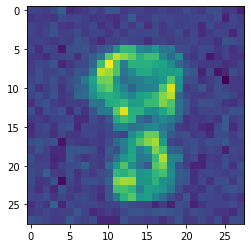

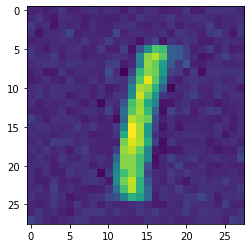

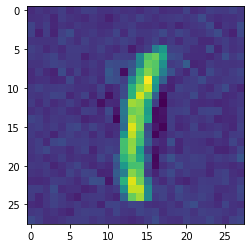

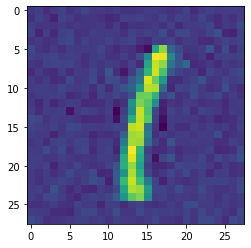

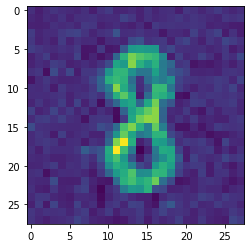

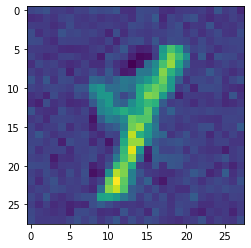

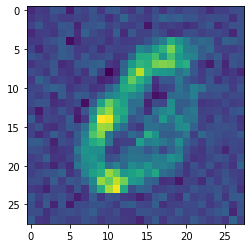

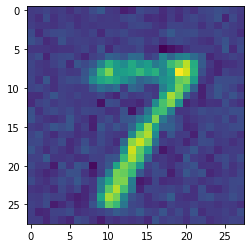

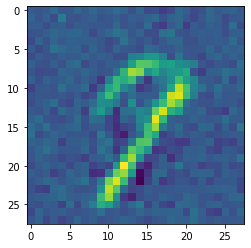

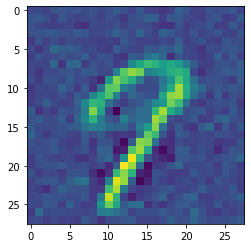

In [ ]:
for i in range(10):
    plt.imshow(G(torch.randn(x.size(0), z_dim, device=device))[i].detach().cpu().reshape((28, 28)))
    plt.show()

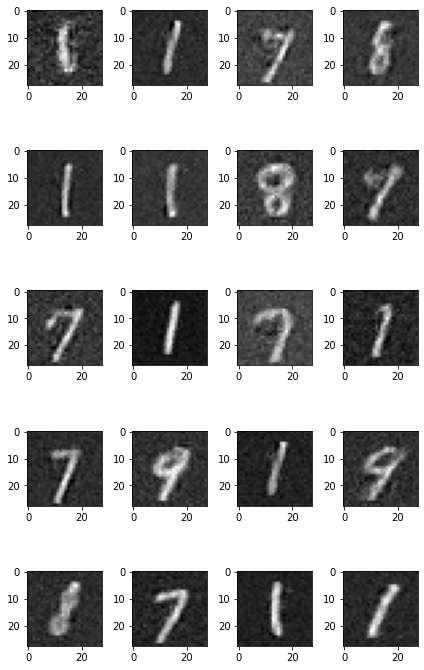

In [ ]:
num = 20
num_row = 5
num_col = 4

fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
images = [G(torch.randn(x.size(0), z_dim, device=device))[i].detach().cpu().reshape((28, 28)) for i in range(num)]
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    # ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()

## Interpolation

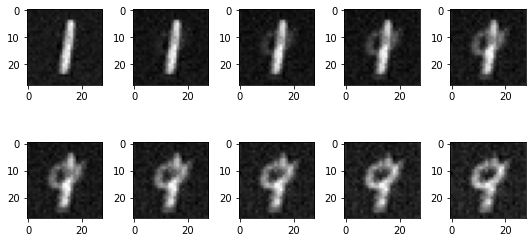

In [ ]:
num = 10
num_row = 2
num_col = 5

fig,axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
latent_samples = G(torch.randn(2, z_dim, device=device))
latent_samples = latent_samples.detach().cpu().reshape((-1,28,28))
A = latent_samples[0,:]
B = latent_samples[1,:]
images = [A*(1-alpha)+ B * alpha for alpha in np.arange(0,1,1./num)]
for i in range(num):
    ax = axes[i//num_col,i%num_col]
    ax.imshow(images[i], cmap='gray')
plt.tight_layout()
plt.show()
